### visualize data

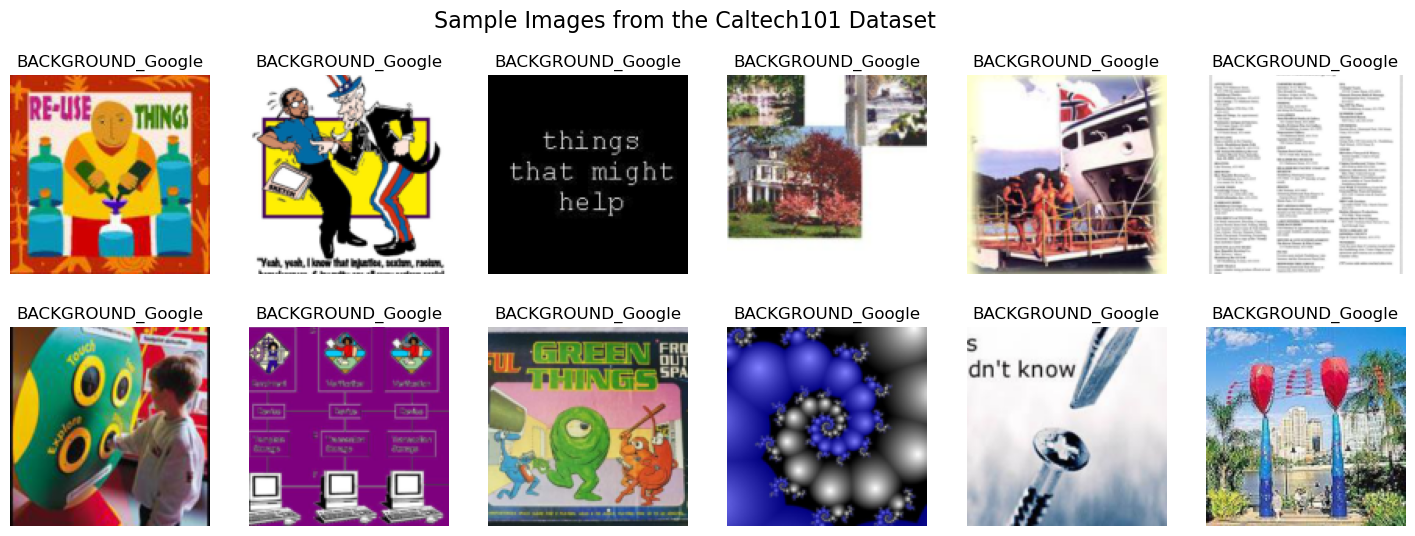

In [1]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define dataset path
dataset_path = "d:/Muzny Zuhair/App/Caltech101/caltech101"

# Define transforms
tp = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

# Load the dataset
dst = datasets.ImageFolder(os.path.join(dataset_path, "101_ObjectCategories"), transform=tp)

# Create a figure with 2 rows and 6 columns
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

# Plot 12 images
for i in range(12):
    img, label = dst[i]
    axes[i].imshow(tt(img))
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(dst.classes[label])

# Set the title for the plot
plt.suptitle('Sample Images from the Caltech101 Dataset', fontsize=16)
plt.show()


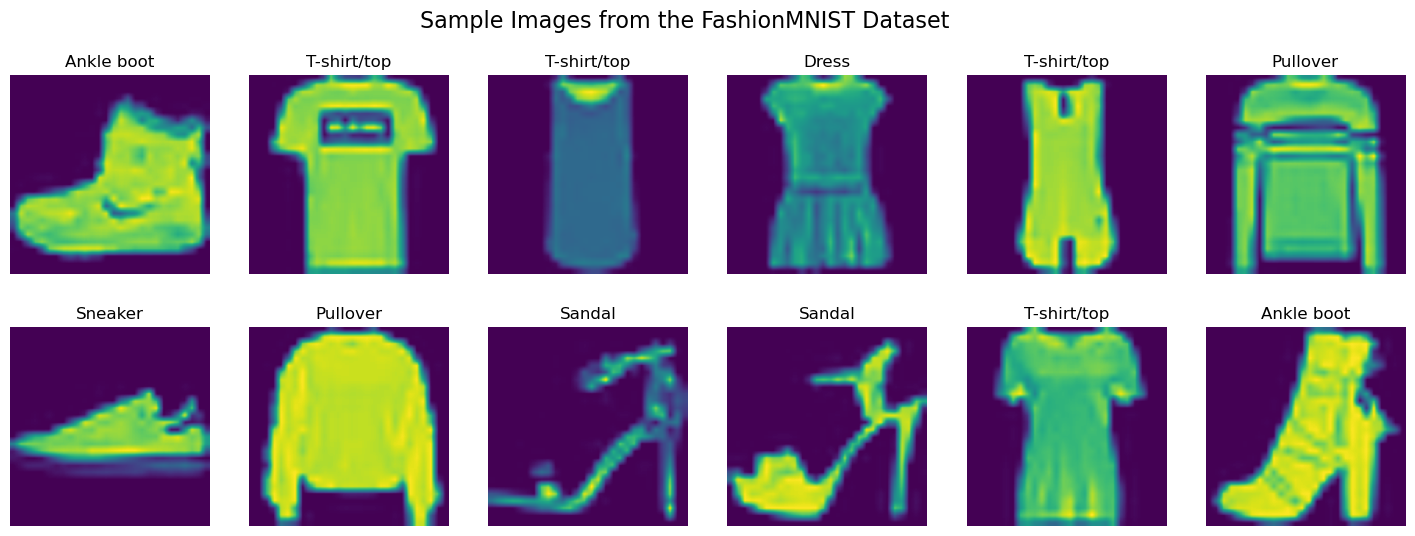

In [2]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define transforms for FashionMNIST
tp_fashionmnist = transforms.Compose([
    transforms.Resize(128),  # Resize to 128x128
    transforms.CenterCrop(128),  # Center crop to 128x128
    transforms.ToTensor()  # Convert to tensor
])
tt_fashionmnist = transforms.ToPILImage()

# Load the FashionMNIST dataset
dataset_path_fashionmnist = "d:/Muzny Zuhair/App/FashionMNIST"
dst_fashionmnist = datasets.FashionMNIST(root=dataset_path_fashionmnist, train=True, download=True, transform=tp_fashionmnist)

# Create a figure with 2 rows and 6 columns
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

# Plot 12 images
for i in range(12):
    img, label = dst_fashionmnist[i]
    axes[i].imshow(tt_fashionmnist(img))
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(dst_fashionmnist.classes[label])

# Set the title for the plot
plt.suptitle('Sample Images from the FashionMNIST Dataset', fontsize=16)
plt.show()


### perform data complexity

#### reusable code for deep leakage attack 

In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import datasets, transforms

# Define the models outside the run_experiment function
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)  # 10 classes for FashionMNIST and Caltech101
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class LeNetExtended(nn.Module):
    def __init__(self):
        super(LeNetExtended, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)  # 10 classes for FashionMNIST and Caltech101
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def run_experiment(dataset_type="FashionMNIST", batch_size=2, model_class=None):
    # Set the seed for reproducibility
    torch.manual_seed(50)

    # Check versions
    print(torch.__version__, torchvision.__version__)

    # Define dataset path based on dataset type
    if dataset_type == "FashionMNIST":
        dataset_path = "d:/Muzny Zuhair/App/FashionMNIST"
    elif dataset_type == "Caltech101":
        dataset_path = "d:/Muzny Zuhair/App/Caltech101/caltech101/101_ObjectCategories"
    else:
        raise ValueError("Unsupported dataset type. Choose either 'FashionMNIST' or 'Caltech101'.")

    # Define transforms based on dataset type
    if dataset_type == "FashionMNIST":
        tp = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor()
        ])
    elif dataset_type == "Caltech101":
        tp = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
        ])
    tt = transforms.ToPILImage()

    # Set device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    print("Running on %s" % device)

    # Helper functions
    def label_to_onehot(target, num_classes=10):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    # Load the dataset
    if dataset_type == "FashionMNIST":
        dst = datasets.FashionMNIST(dataset_path, train=True, download=True, transform=tp)
    elif dataset_type == "Caltech101":
        dst = datasets.ImageFolder(dataset_path, transform=tp)

    # Fixed set of images
    fixed_img_indices = [0, 1, 2, 3, 4, 5, 6, 7]  # Change these indices if you want different images
    fixed_gt_data = torch.stack([dst[i][0] for i in fixed_img_indices]).to(device)
    fixed_gt_labels = torch.Tensor([dst[i][1] for i in fixed_img_indices]).long().to(device)
    fixed_gt_onehot_labels = label_to_onehot(fixed_gt_labels, num_classes=10)

    # Adjust batch size
    gt_data = fixed_gt_data[:batch_size]
    gt_labels = fixed_gt_labels[:batch_size]
    gt_onehot_labels = fixed_gt_onehot_labels[:batch_size]

    # Plot ground truth images
    fig, axes = plt.subplots(1, batch_size, figsize=(10, 5))
    if batch_size == 1:
        axes.imshow(tt(gt_data[0].cpu()), cmap='gray')
        axes.set_title(f"GT label is {gt_labels[0].item()}")
    else:
        for i in range(batch_size):
            axes[i].imshow(tt(gt_data[i].cpu()), cmap='gray')
            axes[i].set_title(f"GT label is {gt_labels[i].item()}")
    plt.show()

    # Initialize the network
    if model_class is None:
        net = LeNet().to(device)
    else:
        net = model_class().to(device)
    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    # Compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_onehot_labels)
    dy_dx = torch.autograd.grad(y, net.parameters())

    # Share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    # Generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_labels.size()).to(device).requires_grad_(True)

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    # Only save the images at every 10th iteration
    history = []
    mse_values = []
    psnr_values = []
    for iters in range(300):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            # Calculate metrics
            mse = torch.mean((dummy_data - gt_data) ** 2).item()
            psnr = -10 * np.log10(mse) if mse != 0 else float('inf')
            mse_values.append(mse)
            psnr_values.append(psnr)
            # Append the image to history
            history.append([tt(dummy_data[i].cpu()) for i in range(batch_size)])  # Save the image at every 10th iteration

    # Plot the evolution of dummy data and the metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Two subplots: one for images, one for metrics

    # Plot the evolution of dummy data
    ax1.set_title("PSNR Over Iterations (Every 10 Iterations)")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("PSNR")
    ax1.plot(range(10, 301, 10), psnr_values, label='PSNR', color='blue')
    ax1.set_xticks(range(10, 301, 10))
    ax1.set_xticklabels([f'{i*10}' for i in range(1, 31)], rotation=45)
    ax1.set_ylim(0, max(psnr_values) + 10)
    ax1.grid(True)

    # Plot the MSE and PSNR metrics
    ax2.plot(range(10, 301, 10), mse_values, label='MSE', color='red', marker='o')
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("MSE")
    ax2.set_title("MSE over iterations (Every 10 Iterations)")
    ax2.set_xticks(range(10, 301, 10))
    ax2.set_xticklabels([f'{i*10}' for i in range(1, 31)], rotation=45)
    ax2.set_ylim(0, max(mse_values) + 1)
    ax2.grid(True)
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
    

    # Plot dummy data images separately for each original image
    for i in range(batch_size):
        fig, axes = plt.subplots(3, 10, figsize=(30, 10))  # 3 rows and 10 columns
        for j in range(3):
            for k in range(10):
                idx = j * 10 + k
                if idx < len(history):
                    axes[j, k].imshow(history[idx][i], cmap='gray')
                    axes[j, k].axis('off')
                    # Add iteration number to title
                    axes[j, k].set_title(f'{(idx + 1) * 10}th', fontsize=12)  # Set font size for iteration labels
        plt.suptitle(f"Evolution of Dummy Data for Image {i+1} Over Iterations (Every 10 Iterations)", fontsize=16)
        plt.show()
    max_psnr = max(psnr_values)
    min_mse = min(mse_values)
    max_psnr_iteration = (np.array(psnr_values).tolist()).index(max_psnr) * 10 + 10
    min_mse_iteration = (np.array(mse_values).tolist()).index(min_mse) * 10 + 10

    print(f"Maximum PSNR for {dataset_type} datset with {batch_size} batchsize with model of {model_class}: {max_psnr:.2f} at Iteration {max_psnr_iteration}")
    print(f"Minimum MSE for {dataset_type} datset with {batch_size} batchsize with model of {model_class}: {min_mse:.5e} at Iteration {min_mse_iteration}")





### experiment 1 - evaluate attck with different dataset complexity

2.3.1 0.18.1
Running on cpu


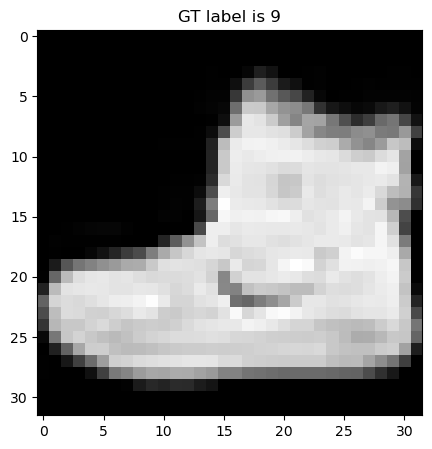

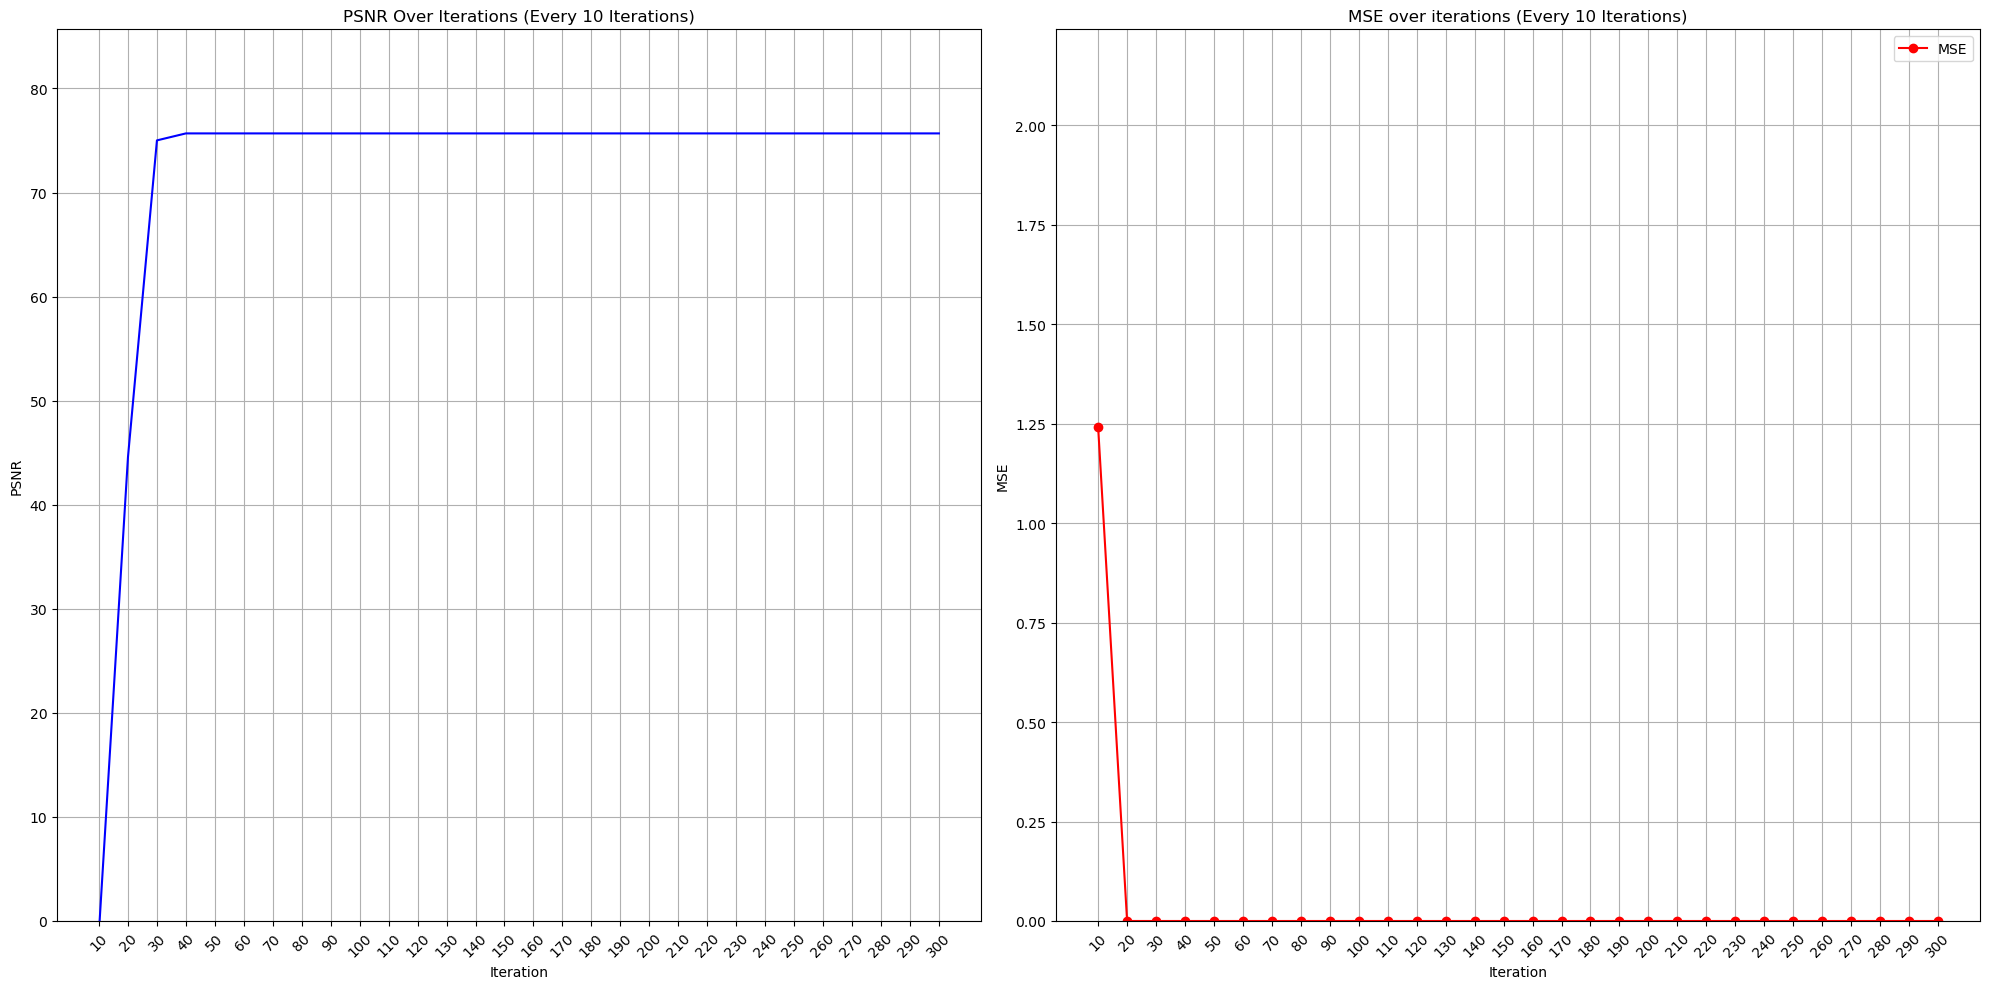

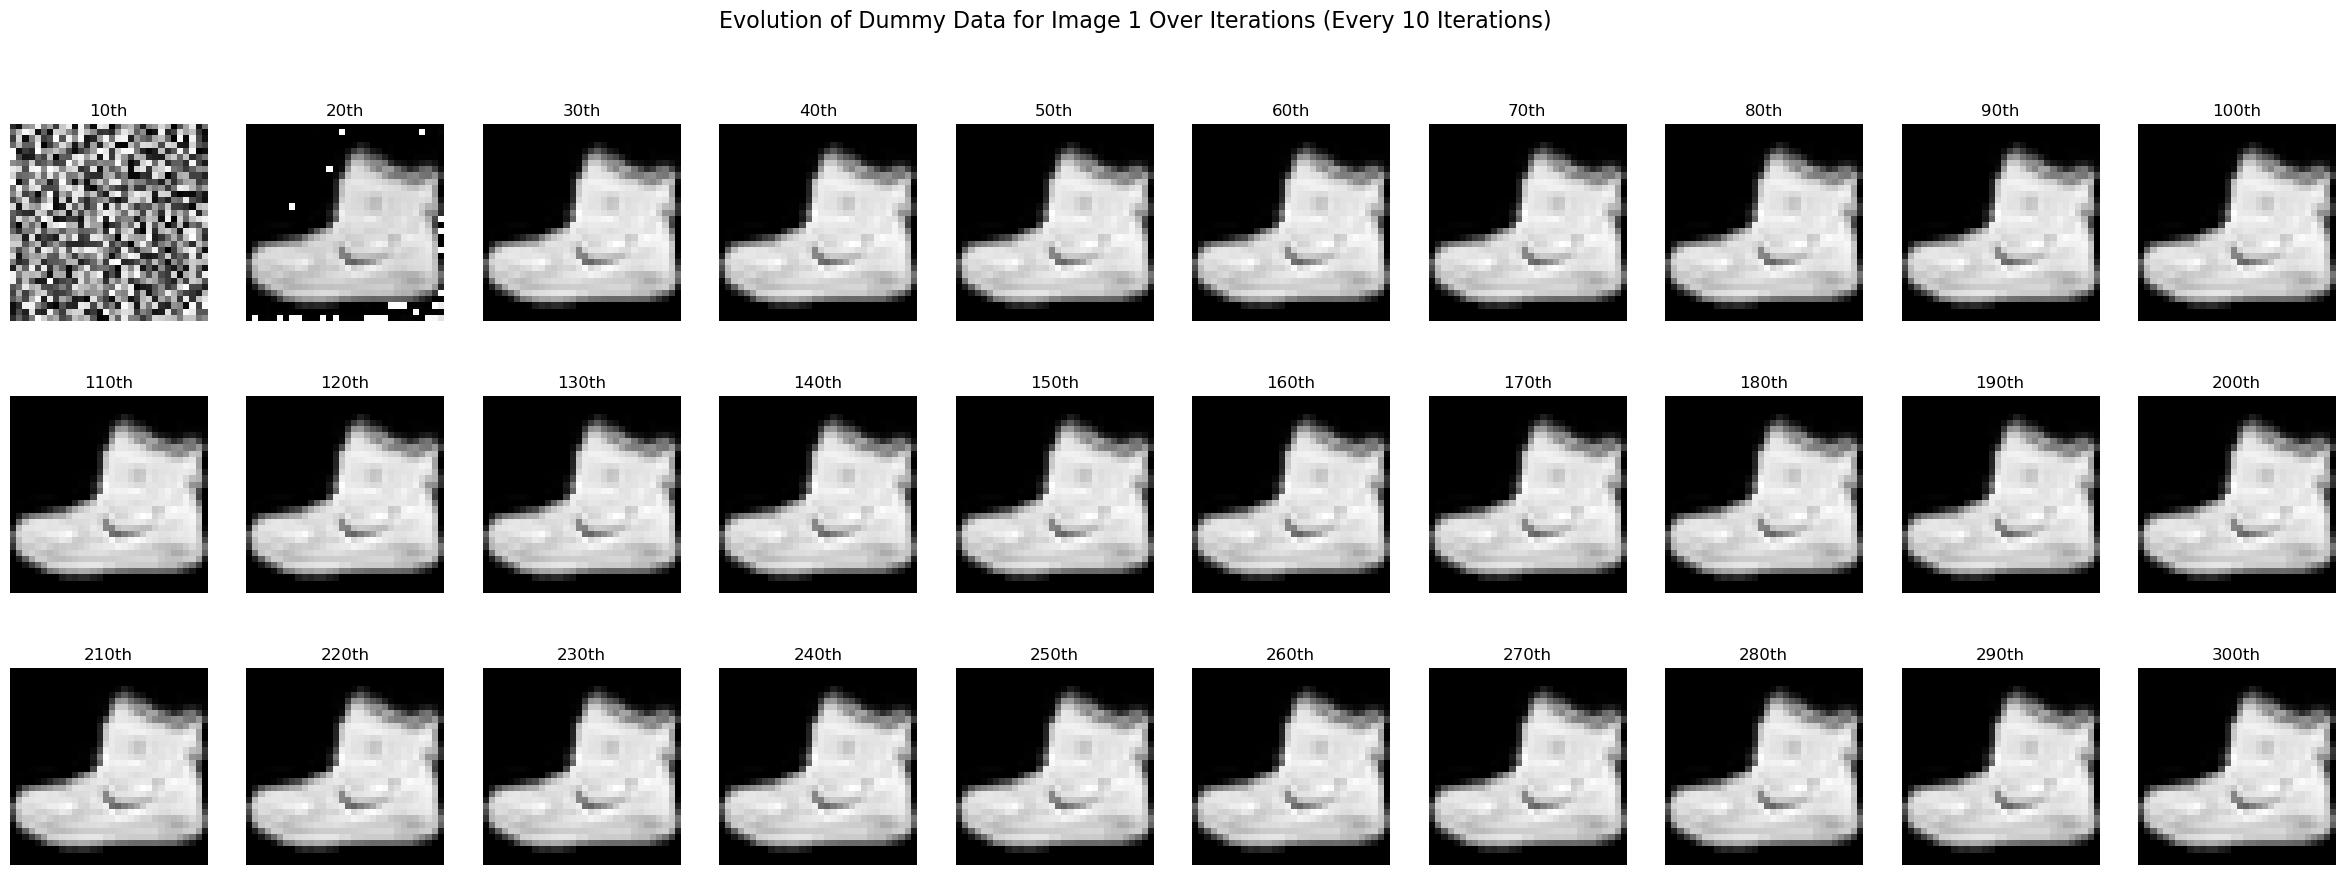

Maximum PSNR for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 75.68 at Iteration 40
Minimum MSE for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 2.70396e-08 at Iteration 40
2.3.1 0.18.1
Running on cpu


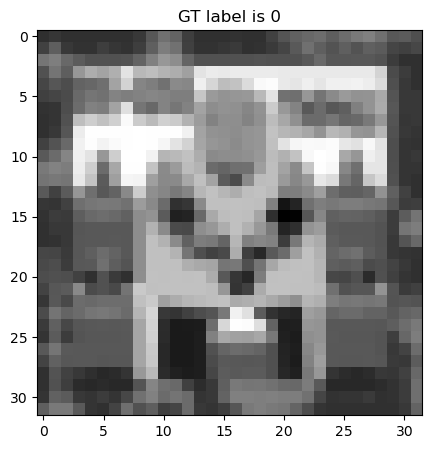

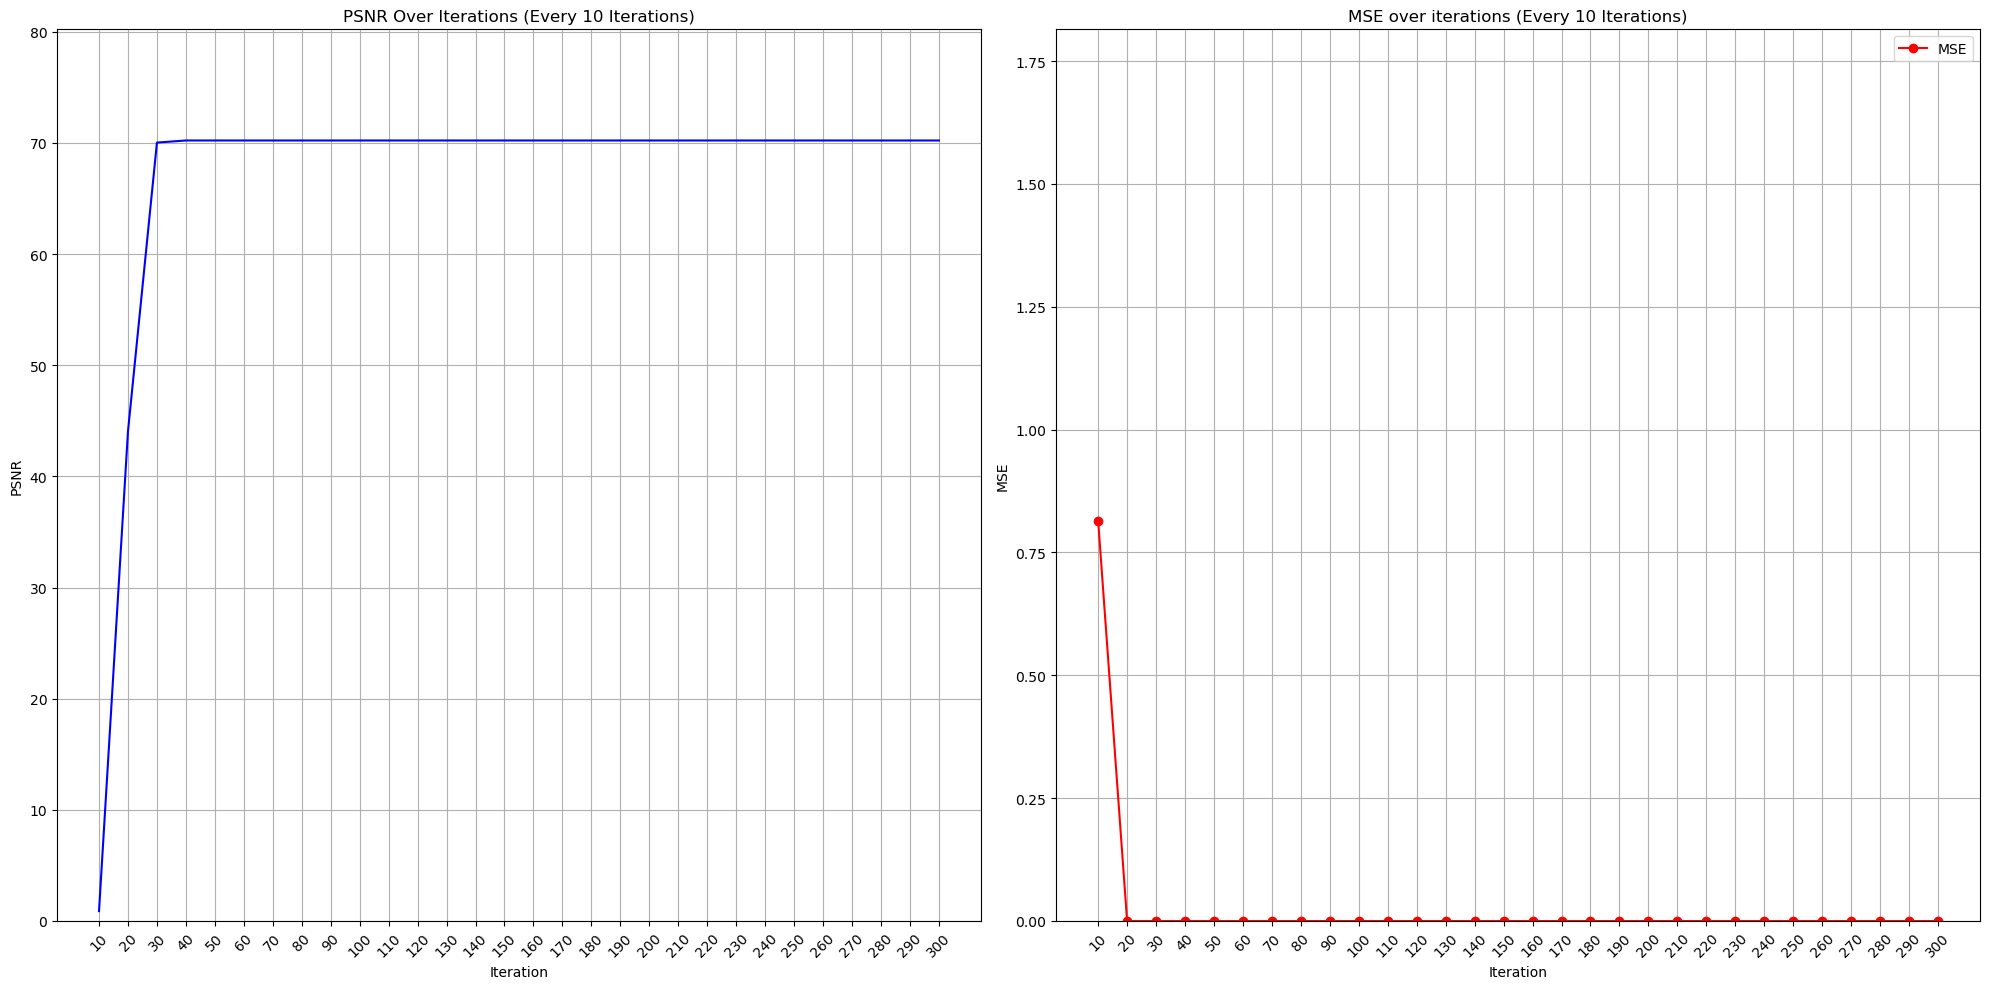

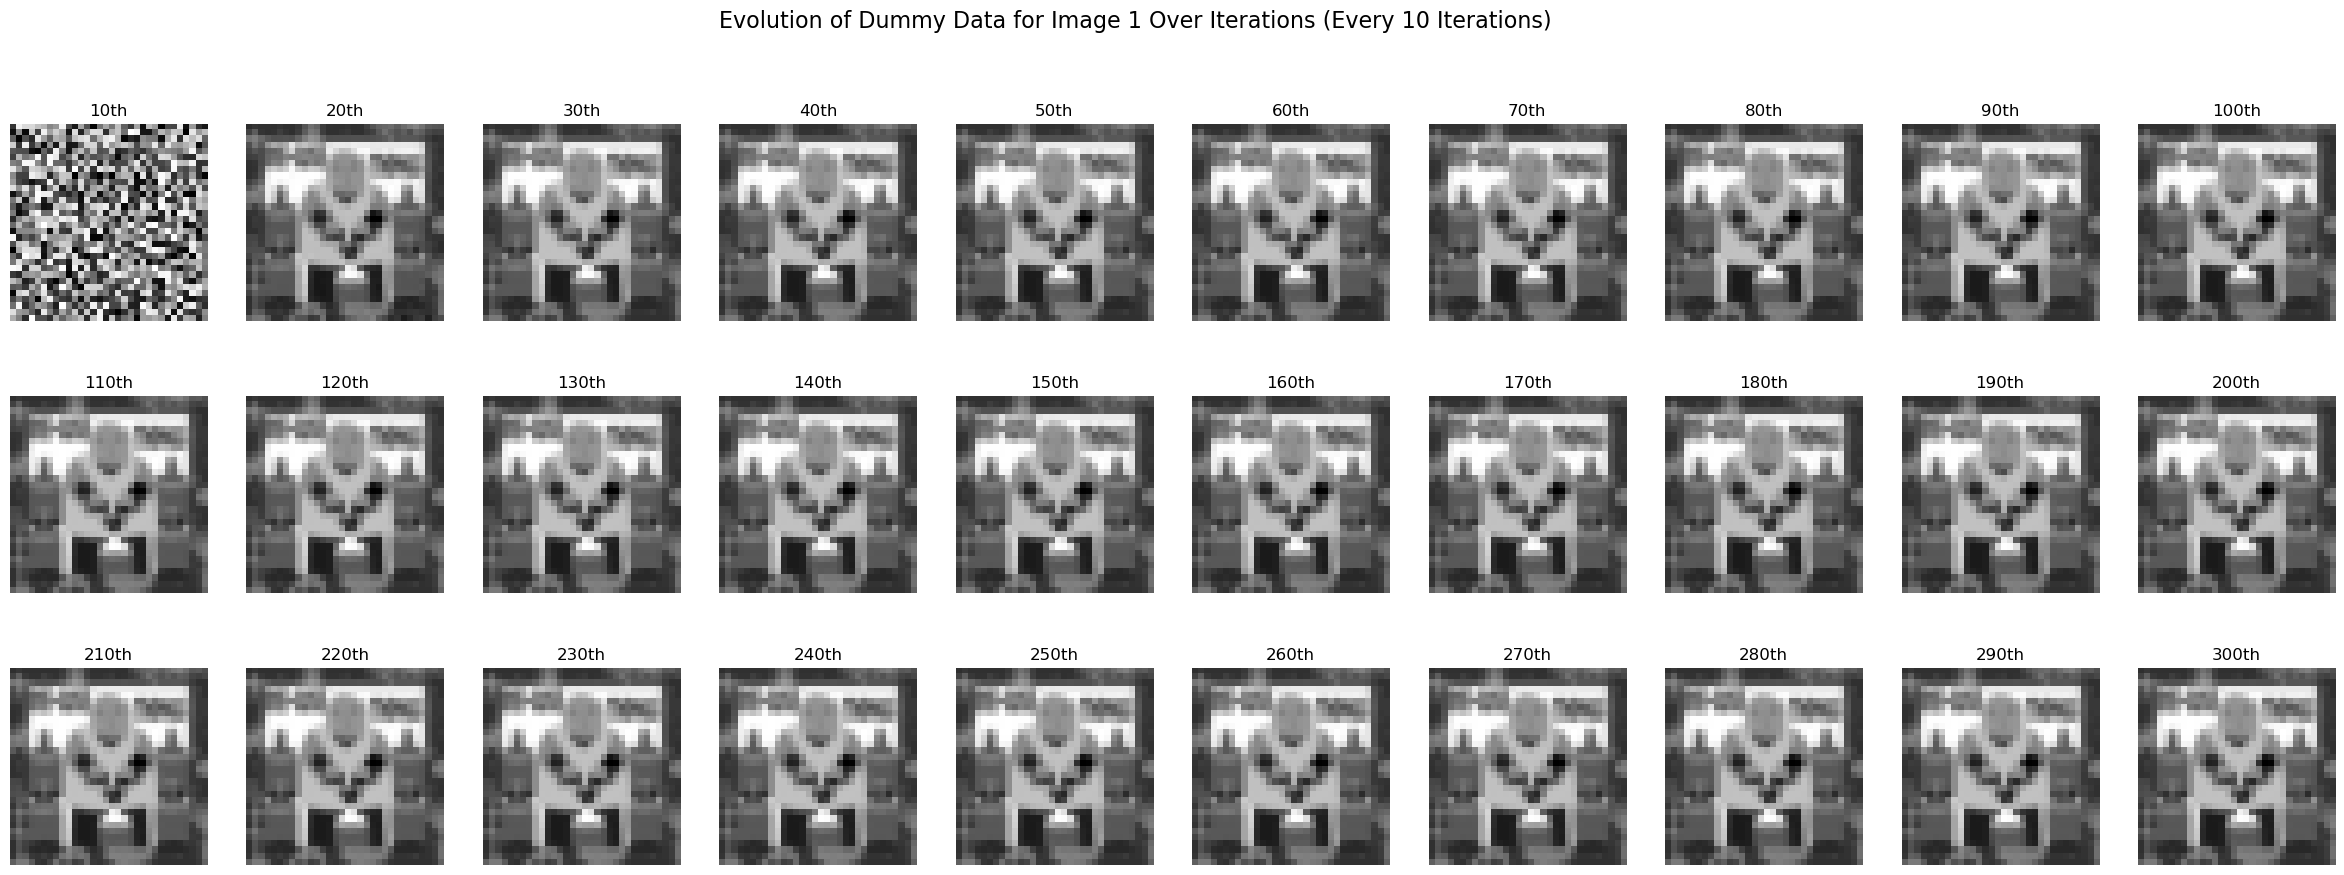

Maximum PSNR for Caltech101 datset with 1 batchsize with model of <class '__main__.LeNet'>: 70.22 at Iteration 40
Minimum MSE for Caltech101 datset with 1 batchsize with model of <class '__main__.LeNet'>: 9.50117e-08 at Iteration 40


In [9]:
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet)
run_experiment(dataset_type="Caltech101", batch_size=1, model_class=LeNet)



#### evaluate attack with differennt batch size


2.3.1 0.18.1
Running on cpu


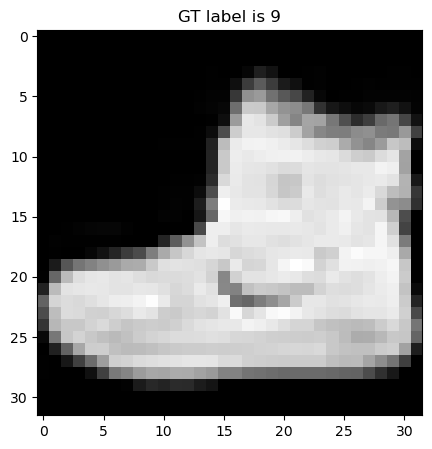

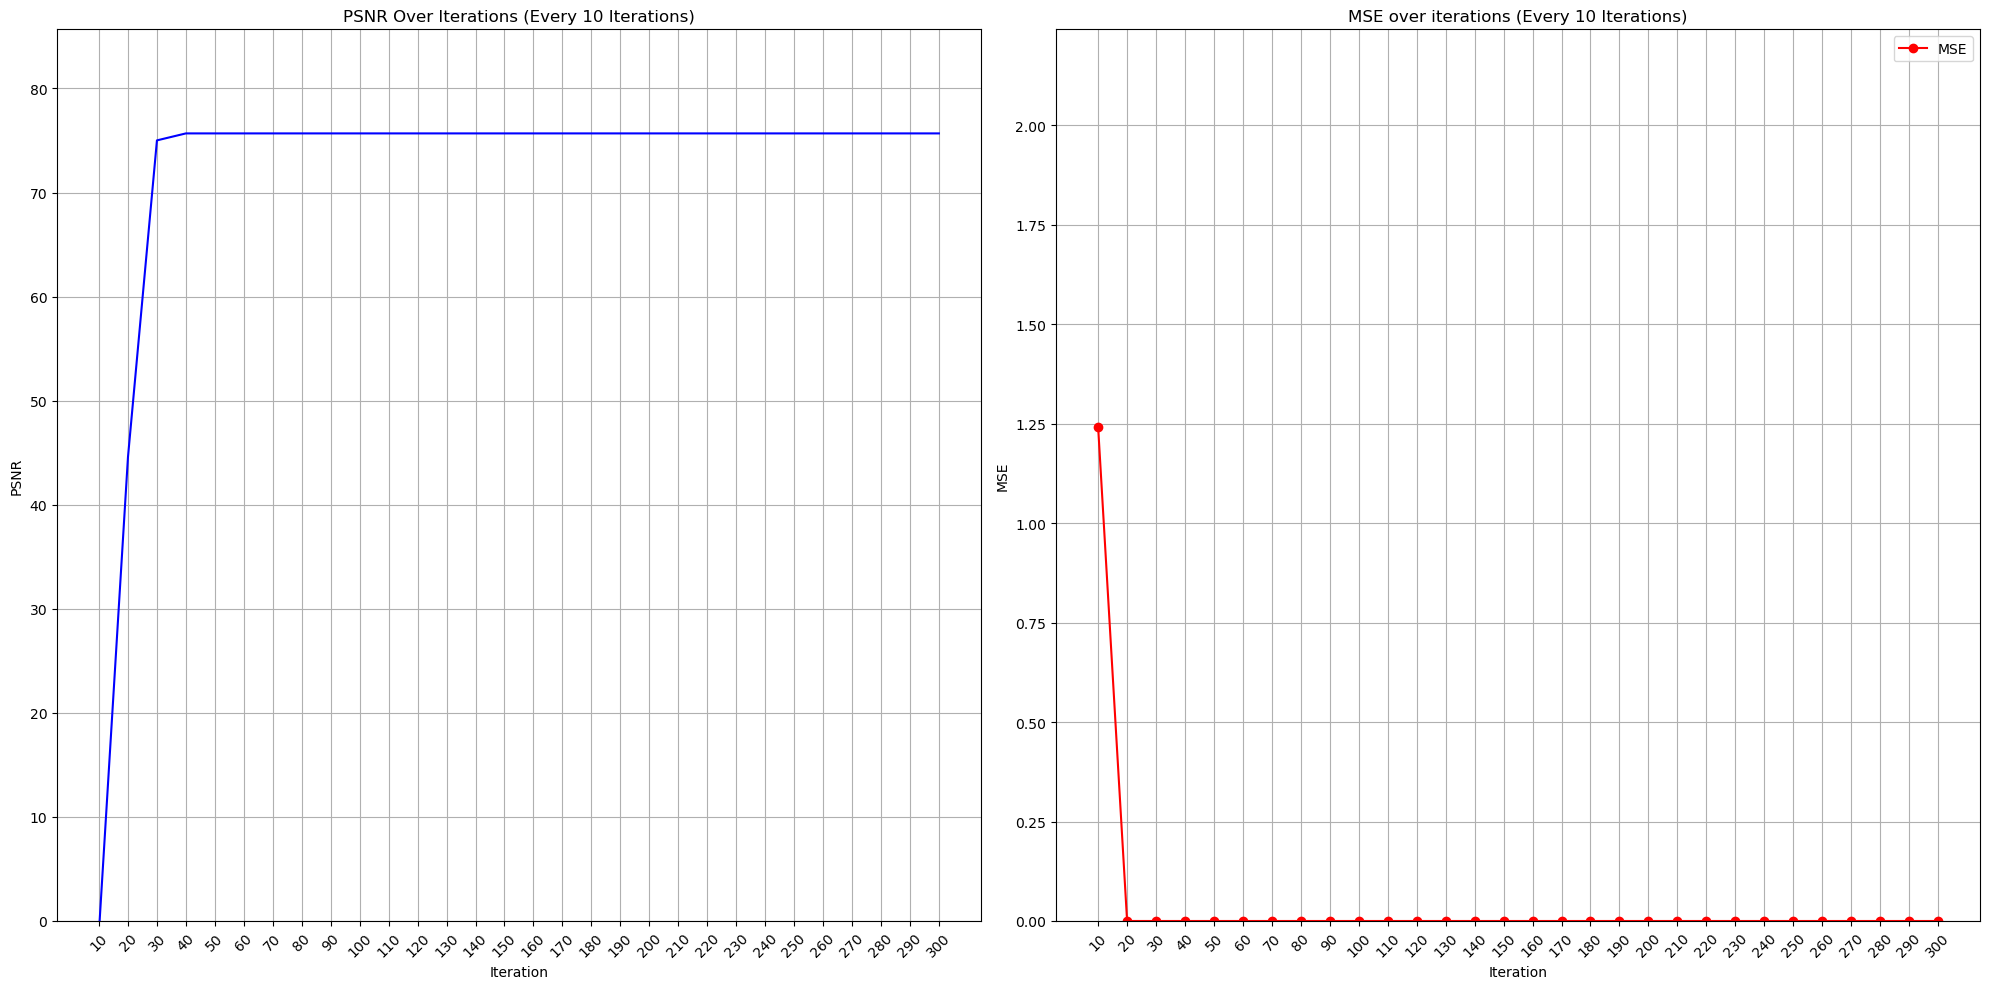

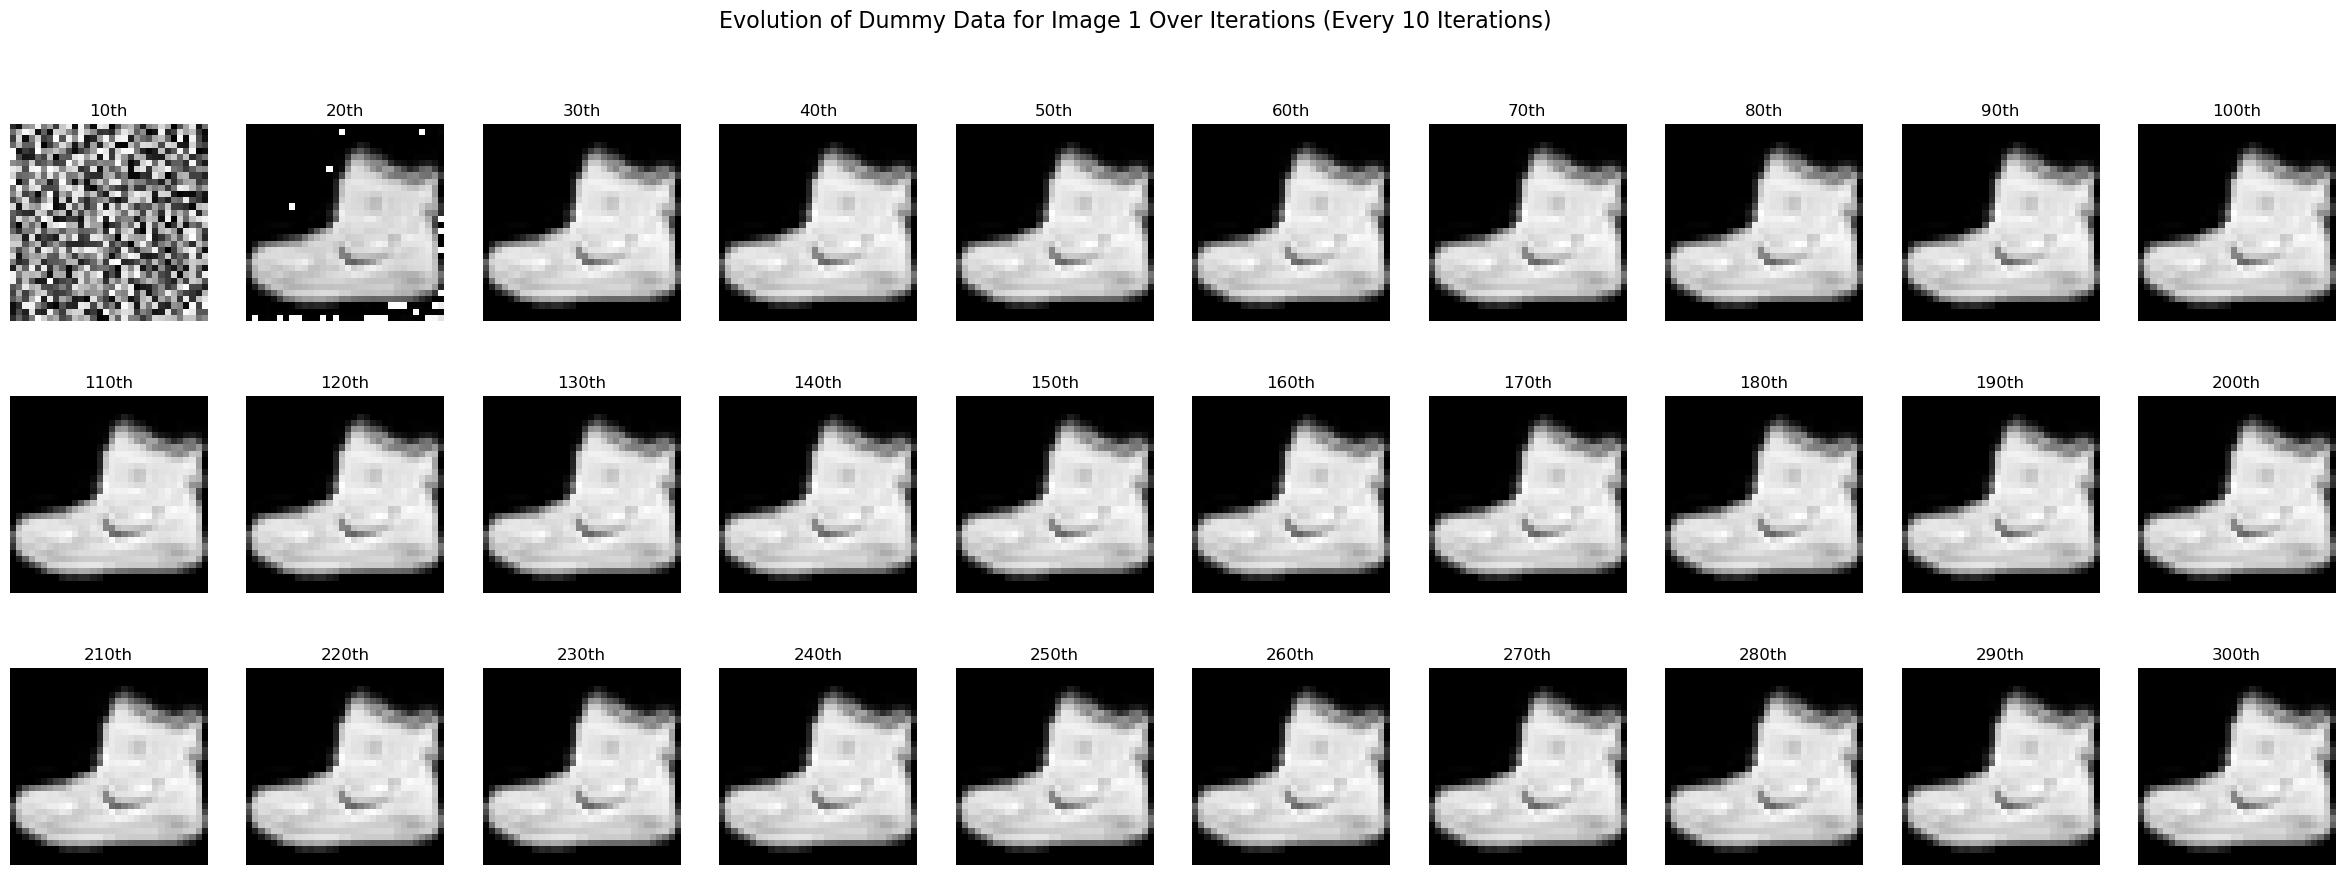

Maximum PSNR for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 75.68 at Iteration 40
Minimum MSE for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 2.70396e-08 at Iteration 40
2.3.1 0.18.1
Running on cpu


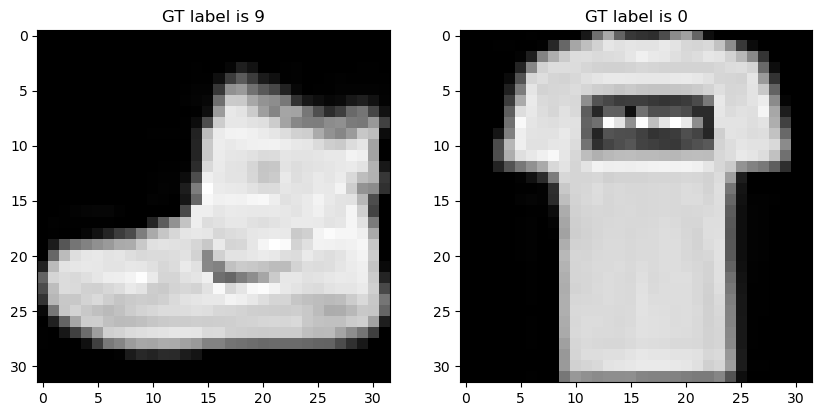

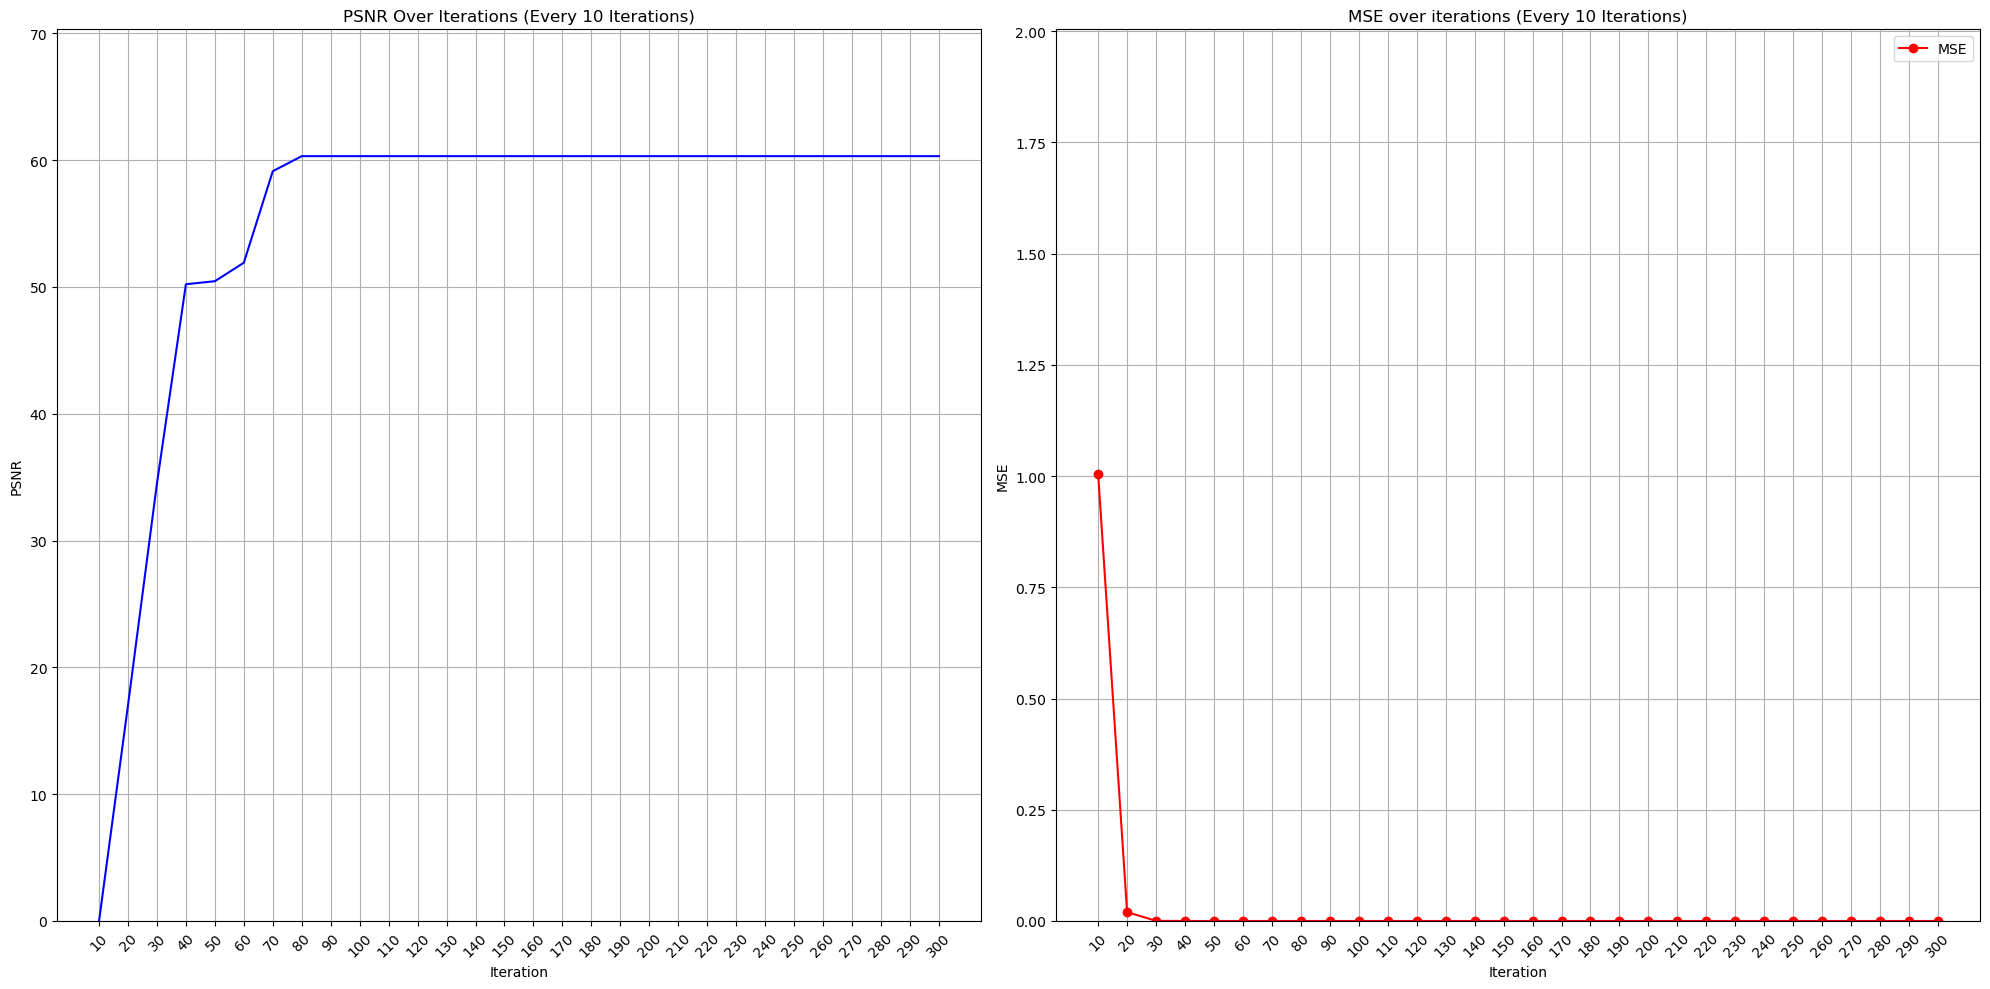

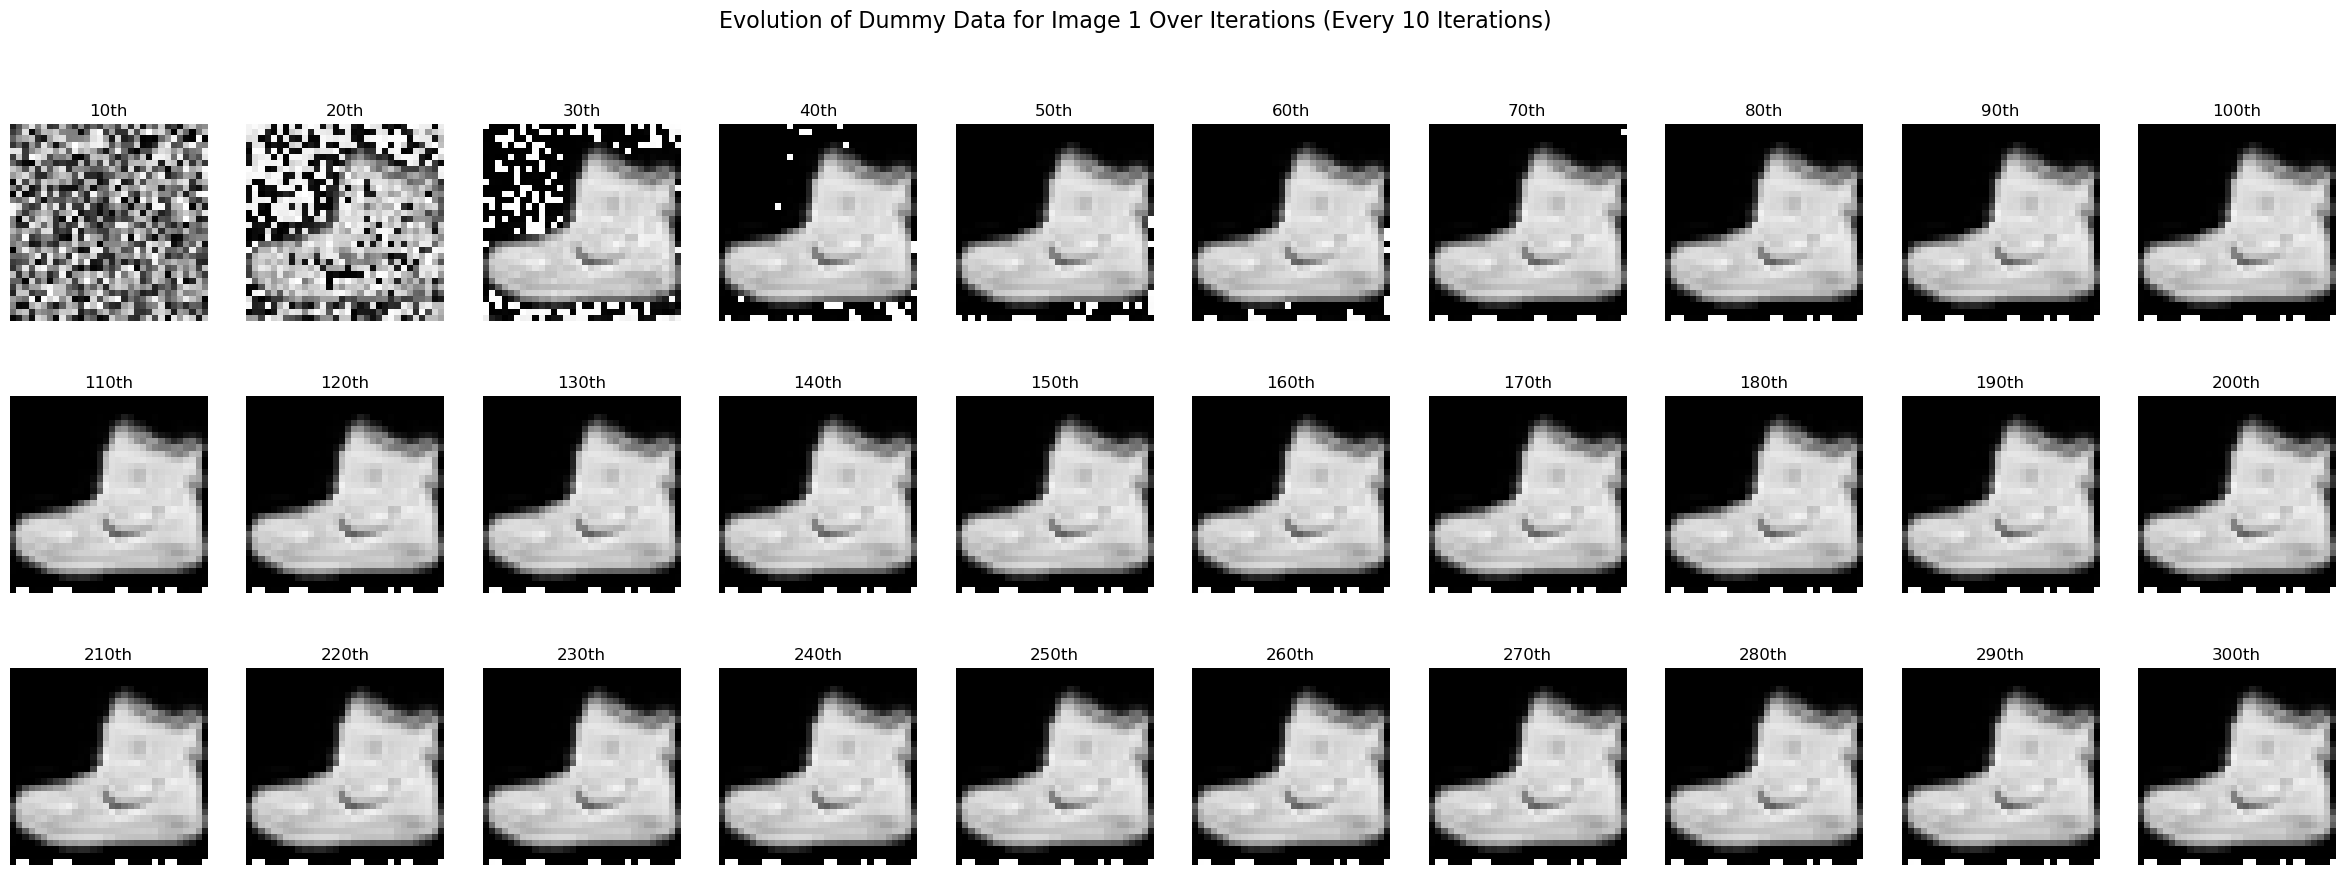

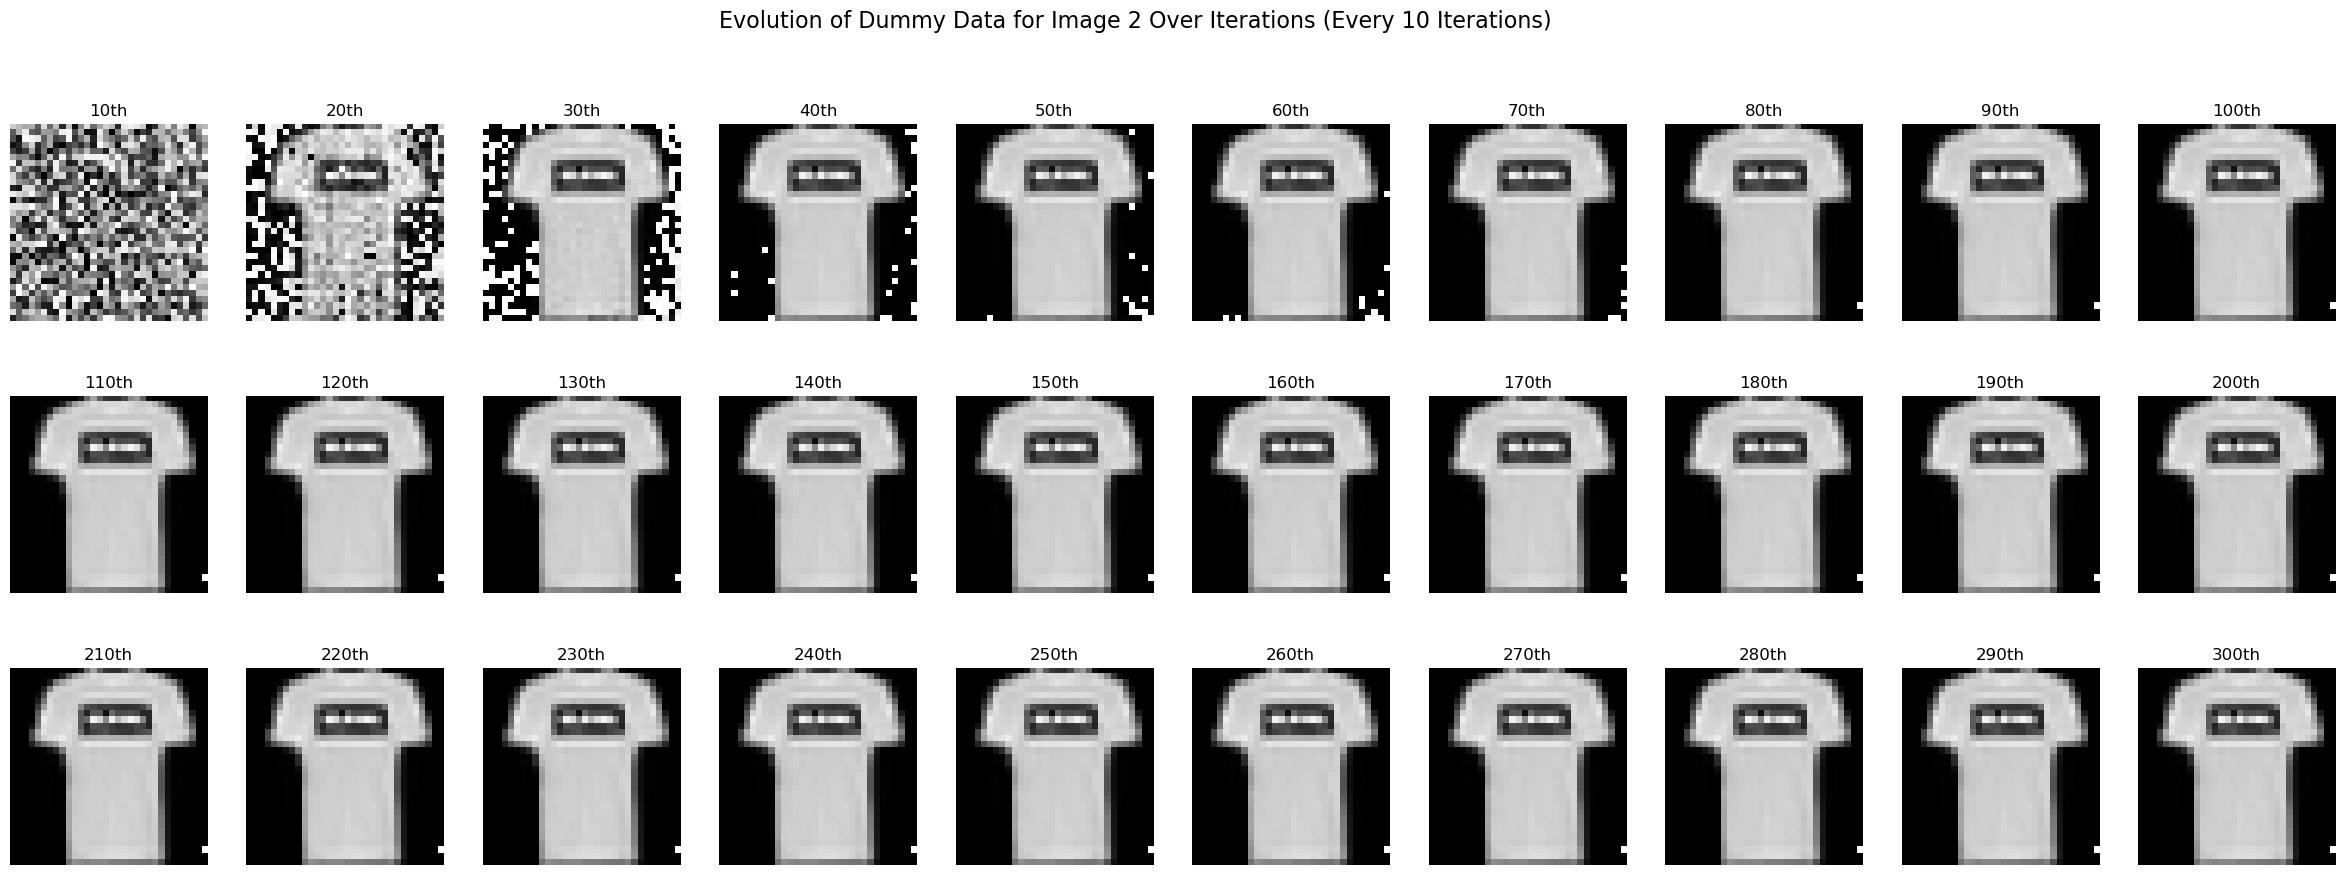

Maximum PSNR for FashionMNIST datset with 2 batchsize with model of <class '__main__.LeNet'>: 60.31 at Iteration 80
Minimum MSE for FashionMNIST datset with 2 batchsize with model of <class '__main__.LeNet'>: 9.30772e-07 at Iteration 80


In [10]:
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet)
run_experiment(dataset_type="FashionMNIST", batch_size=2, model_class=LeNet)



#### evaluate attack with different NN model

2.3.1 0.18.1
Running on cpu


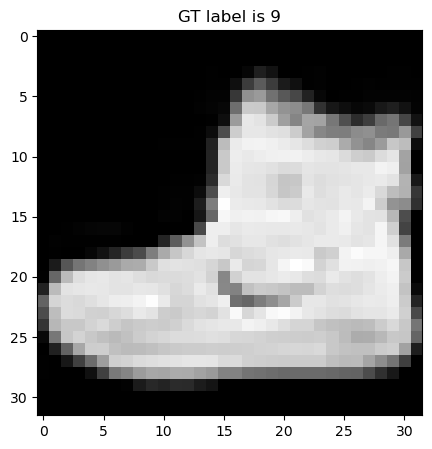

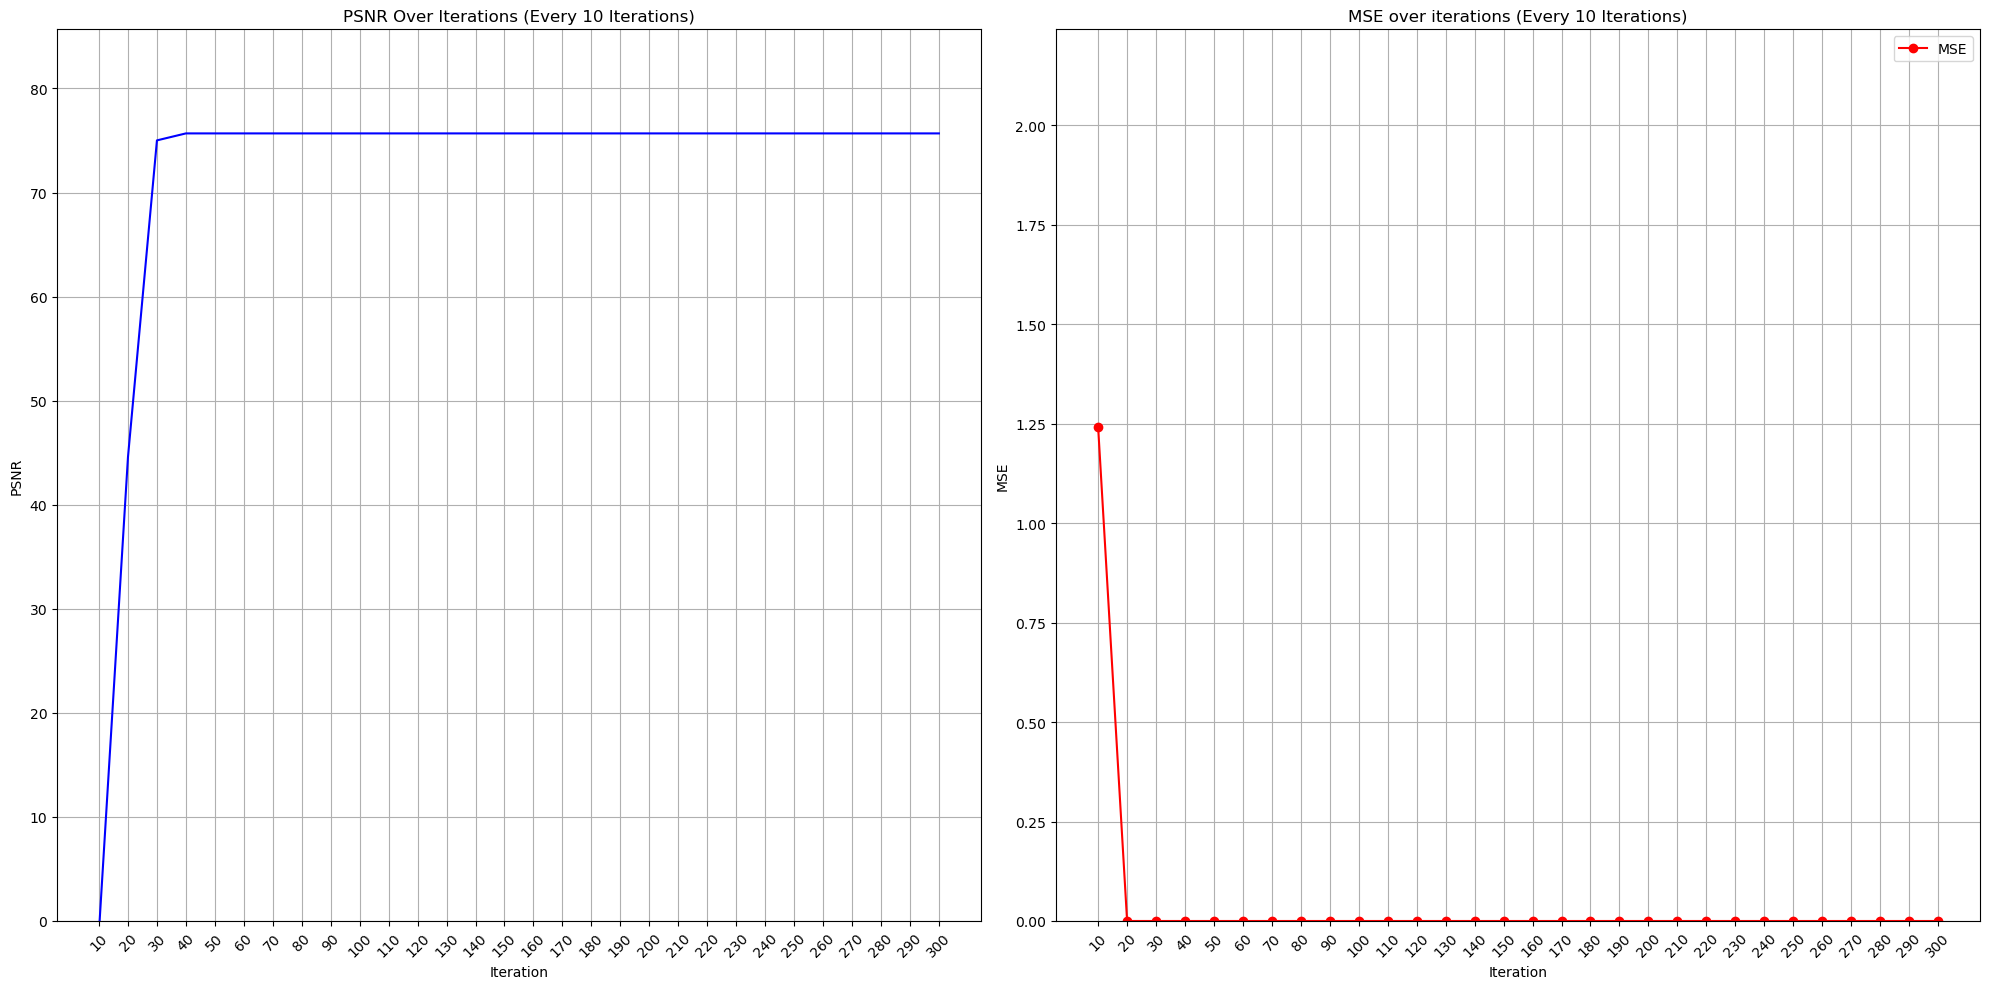

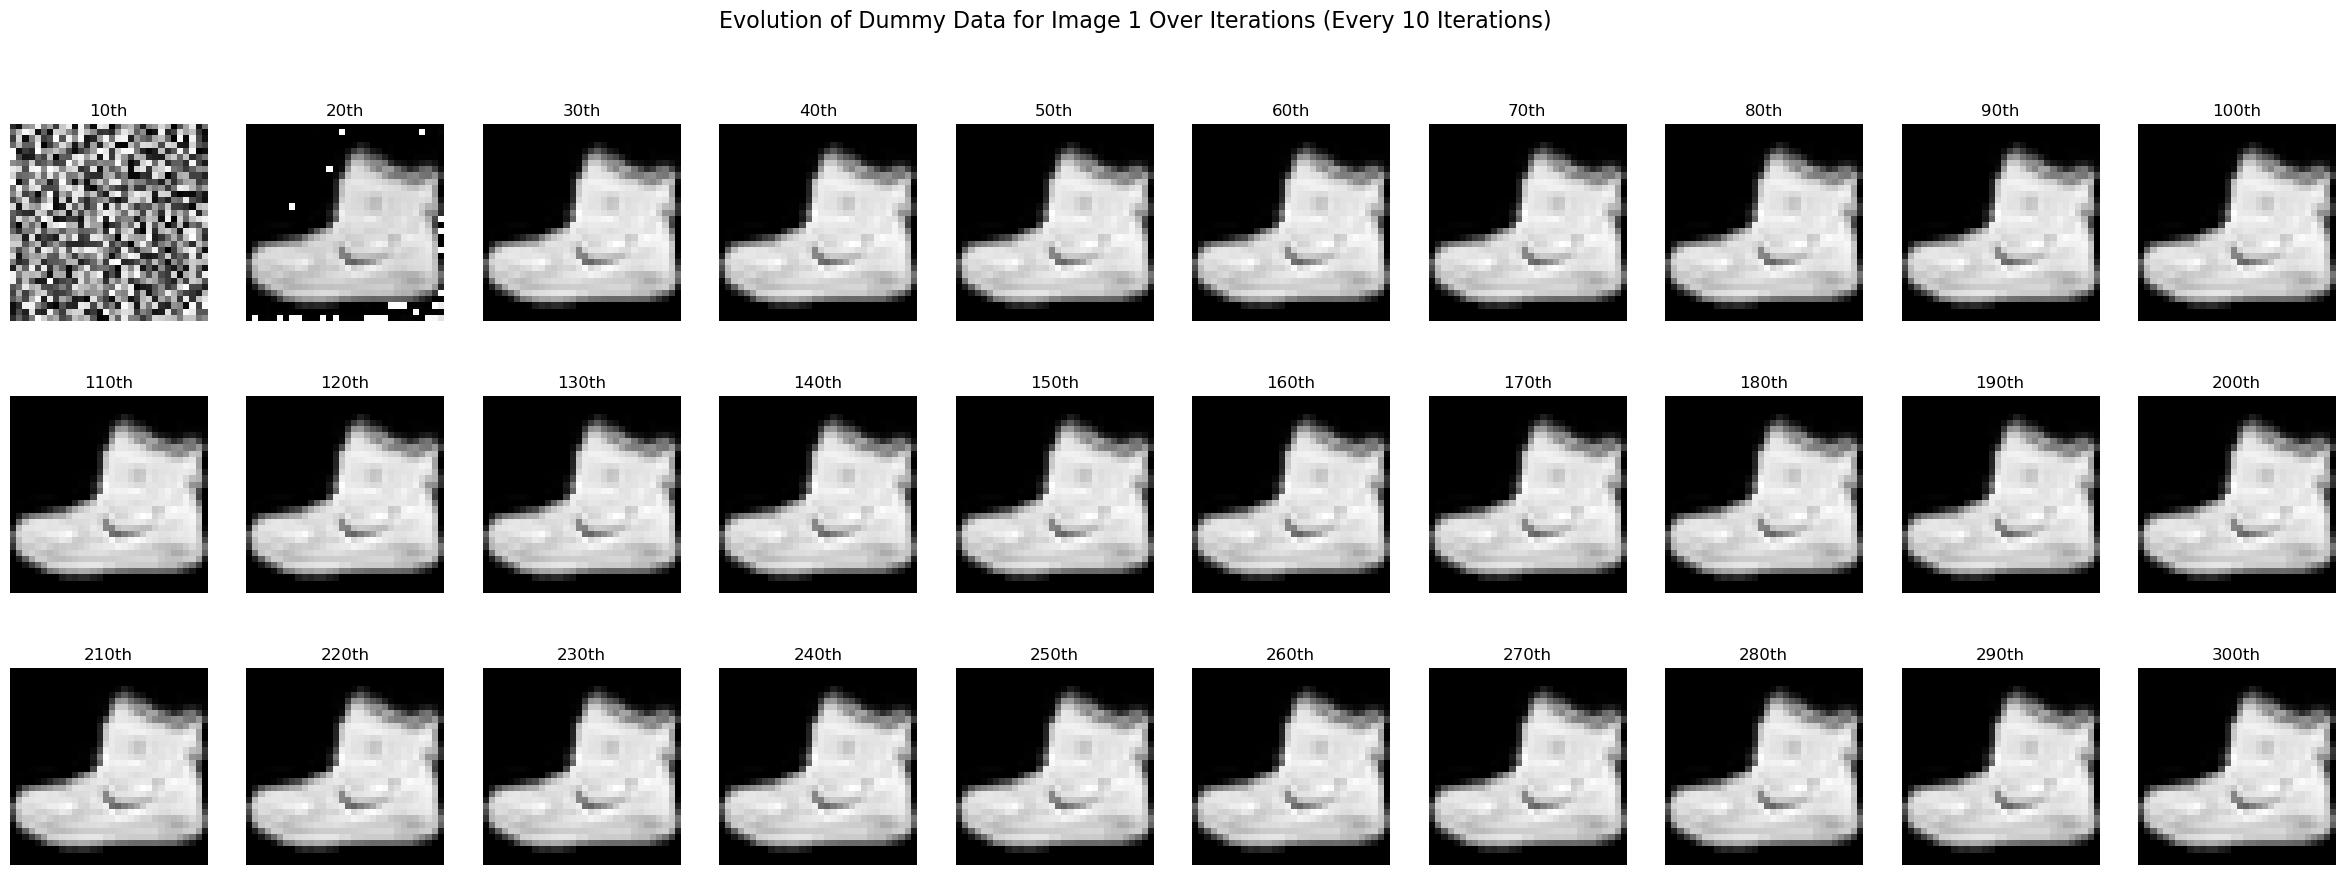

Maximum PSNR for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 75.68 at Iteration 40
Minimum MSE for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNet'>: 2.70396e-08 at Iteration 40
2.3.1 0.18.1
Running on cpu


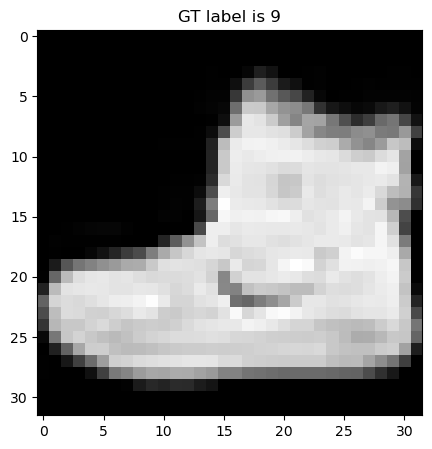

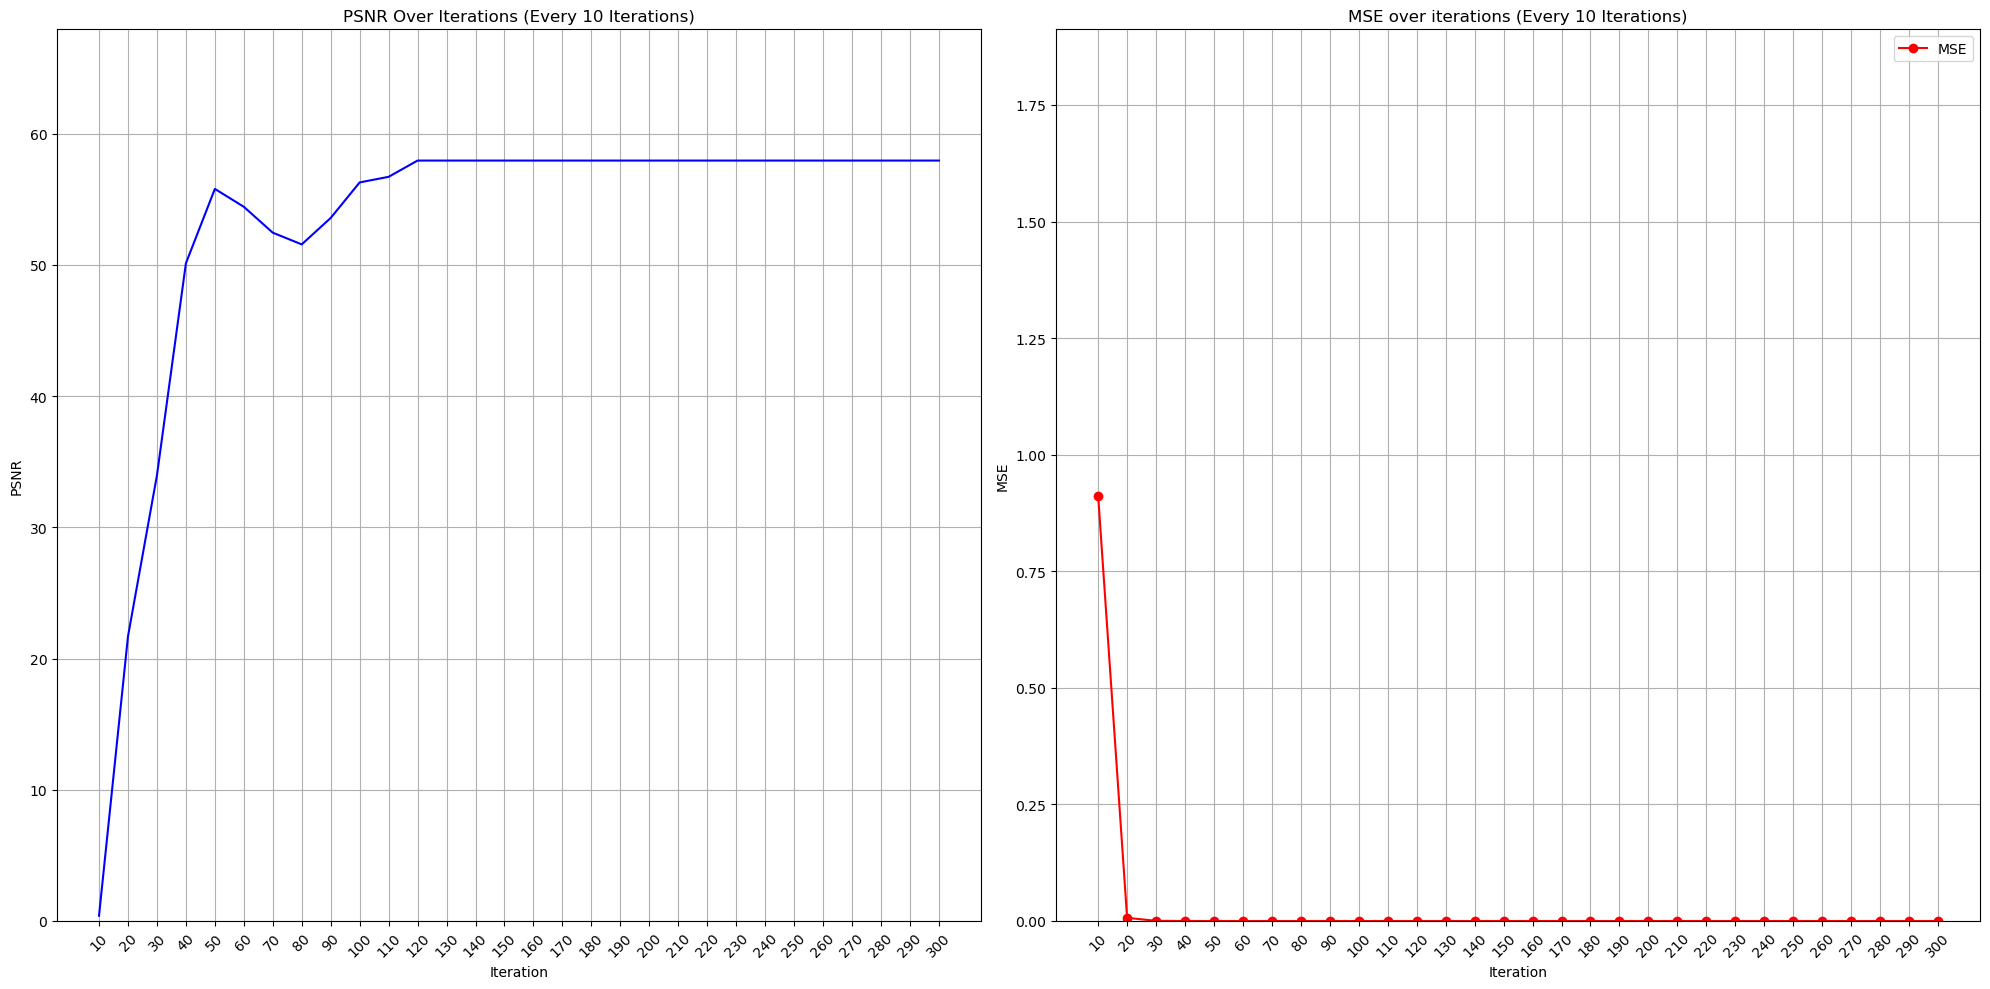

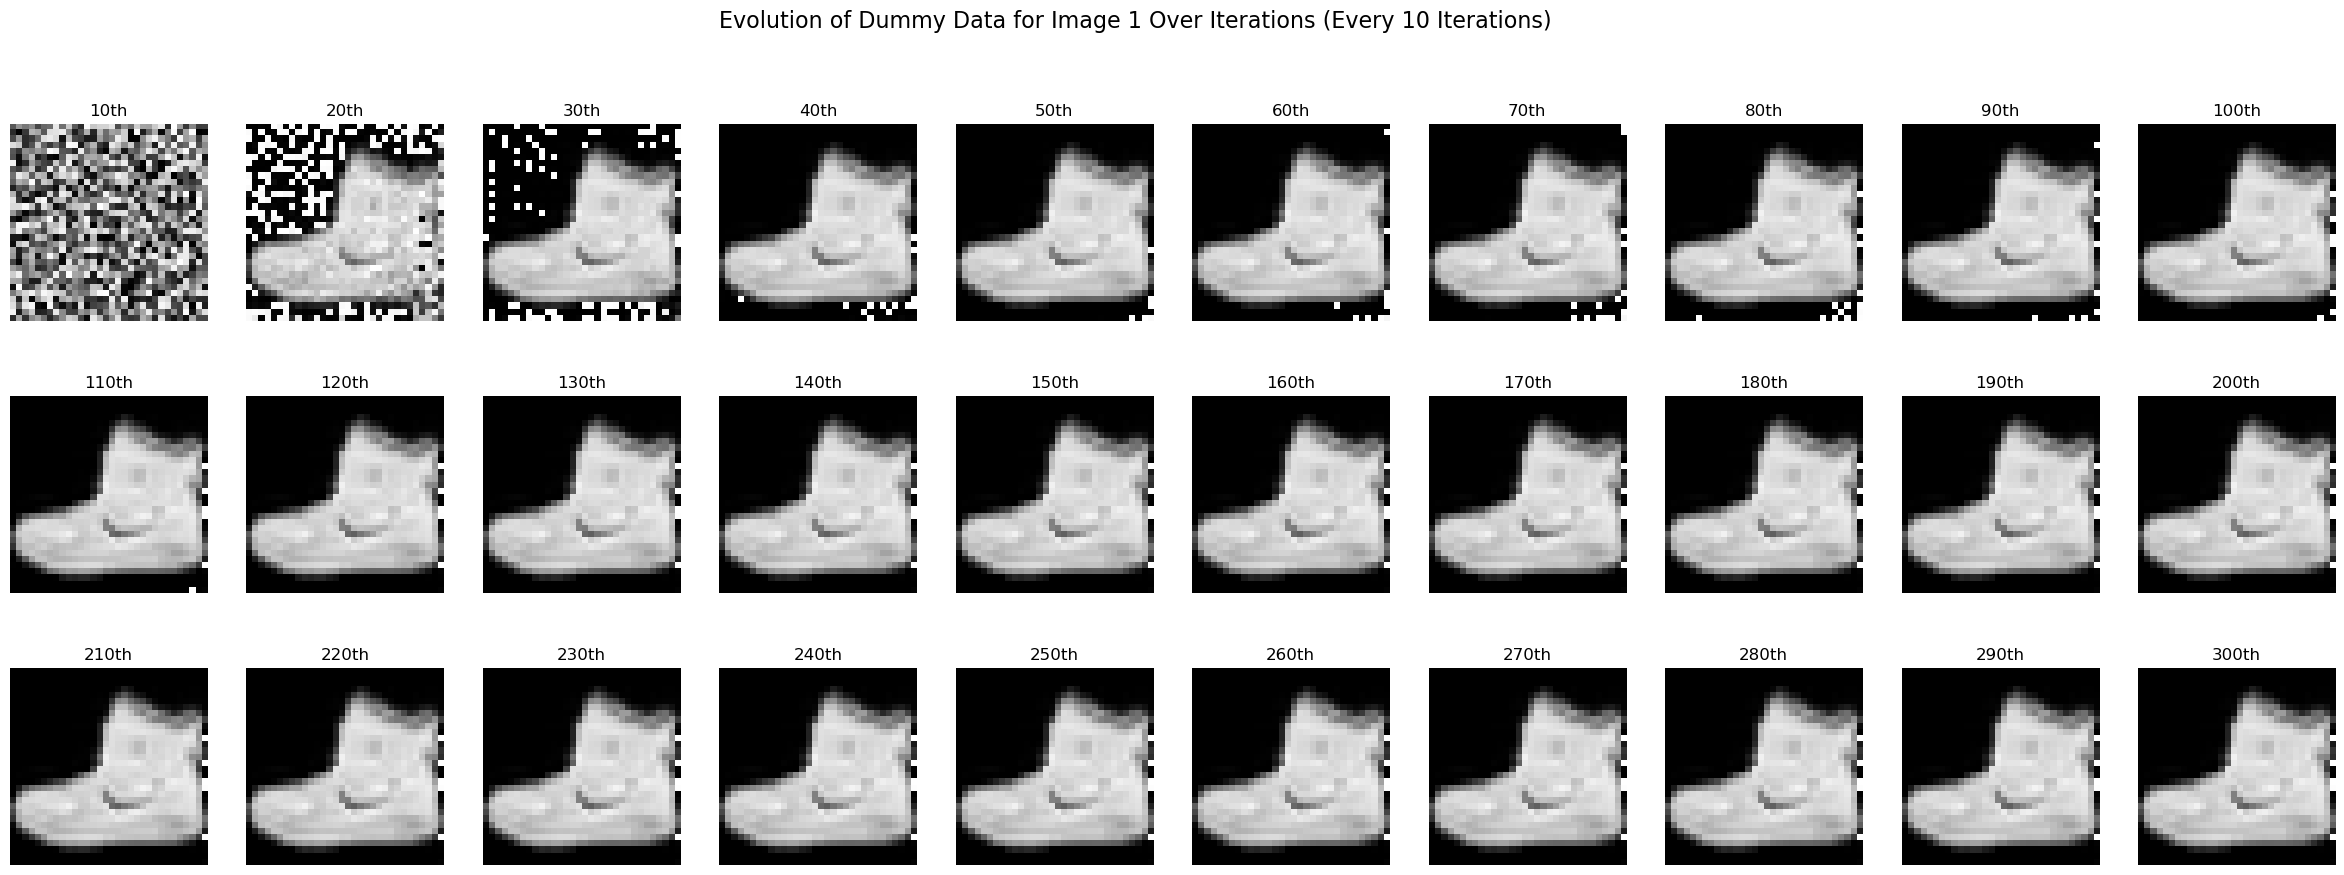

Maximum PSNR for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNetExtended'>: 57.95 at Iteration 120
Minimum MSE for FashionMNIST datset with 1 batchsize with model of <class '__main__.LeNetExtended'>: 1.60465e-06 at Iteration 120


In [11]:

run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet)

run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNetExtended)


### Privacy added


#### reusable code

In [19]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import datasets, transforms

# Define the models outside the run_experiment function
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)  # 10 classes for FashionMNIST and Caltech101
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class LeNetExtended(nn.Module):
    def __init__(self):
        super(LeNetExtended, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10)  # 10 classes for FashionMNIST and Caltech101
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def add_noise_to_gradients(gradients, noise_type="Gaussian", noise_strength=0.1):
    """Add noise to the gradients."""
    for i in range(len(gradients)):
        if noise_type == "Gaussian":
            noise = torch.randn_like(gradients[i]) * noise_strength
        elif noise_type == "Laplacian":
            noise = torch.distributions.Laplace(0, noise_strength).sample(gradients[i].size())
        else:
            raise ValueError("Unsupported noise type. Choose 'Gaussian' or 'Laplacian'.")
        gradients[i].add_(noise)
    return gradients

def run_experiment(dataset_type="FashionMNIST", batch_size=2, model_class=None, noise_type="Gaussian", noise_strength=0.1):
    # Set the seed for reproducibility
    torch.manual_seed(50)

    # Check versions
    print(torch.__version__, torchvision.__version__)

    # Define dataset path based on dataset type
    if dataset_type == "FashionMNIST":
        dataset_path = "d:/Muzny Zuhair/App/FashionMNIST"
    elif dataset_type == "Caltech101":
        dataset_path = "d:/Muzny Zuhair/App/Caltech101/caltech101/101_ObjectCategories"
    else:
        raise ValueError("Unsupported dataset type. Choose either 'FashionMNIST' or 'Caltech101'.")

    # Define transforms based on dataset type
    if dataset_type == "FashionMNIST":
        tp = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor()
        ])
    elif dataset_type == "Caltech101":
        tp = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
        ])
    tt = transforms.ToPILImage()

    # Set device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    print("Running on %s" % device)

    # Helper functions
    def label_to_onehot(target, num_classes=10):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)

    # Load the dataset
    if dataset_type == "FashionMNIST":
        dst = datasets.FashionMNIST(dataset_path, train=True, download=True, transform=tp)
    elif dataset_type == "Caltech101":
        dst = datasets.ImageFolder(dataset_path, transform=tp)

    # Fixed set of images
    fixed_img_indices = [0, 1, 2, 3, 4, 5, 6, 7]  # Change these indices if you want different images
    fixed_gt_data = torch.stack([dst[i][0] for i in fixed_img_indices]).to(device)
    fixed_gt_labels = torch.Tensor([dst[i][1] for i in fixed_img_indices]).long().to(device)
    fixed_gt_onehot_labels = label_to_onehot(fixed_gt_labels, num_classes=10)

    # Adjust batch size
    gt_data = fixed_gt_data[:batch_size]
    gt_labels = fixed_gt_labels[:batch_size]
    gt_onehot_labels = fixed_gt_onehot_labels[:batch_size]

    # Plot ground truth images
    fig, axes = plt.subplots(1, batch_size, figsize=(10, 5))
    if batch_size == 1:
        axes.imshow(tt(gt_data[0].cpu()), cmap='gray')
        axes.set_title(f"GT label is {gt_labels[0].item()}")
    else:
        for i in range(batch_size):
            axes[i].imshow(tt(gt_data[i].cpu()), cmap='gray')
            axes[i].set_title(f"GT label is {gt_labels[i].item()}")
    plt.show()

    # Initialize the network
    if model_class is None:
        net = LeNet().to(device)
    else:
        net = model_class().to(device)
    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    # Compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_onehot_labels)
    dy_dx = torch.autograd.grad(y, net.parameters())

    # Add noise to gradients
    noisy_dy_dx = add_noise_to_gradients(list((_.detach().clone() for _ in dy_dx)), noise_type=noise_type, noise_strength=noise_strength)

    # Generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_labels.size()).to(device).requires_grad_(True)

    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    # Only save the images at every 10th iteration
    history = []
    mse_values = []
    psnr_values = []
    for iters in range(300):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, noisy_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            # Calculate metrics
            mse = torch.mean((dummy_data - gt_data) ** 2).item()
            psnr = -10 * np.log10(mse) if mse != 0 else float('inf')
            mse_values.append(mse)
            psnr_values.append(psnr)
            # Append the image to history
            history.append([tt(dummy_data[i].cpu()) for i in range(batch_size)])

    # Plot the evolution of dummy data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot PSNR evolution
    ax1.set_title("PSNR Evolution Over Iterations (Every 10 Iterations)")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("PSNR")
    ax1.plot(range(10, 301, 10), psnr_values, label='PSNR', color='blue')
    ax1.set_xticks(range(10, 301, 10))
    ax1.set_xticklabels([f'{i*10}' for i in range(1, 31)], rotation=45)
    ax1.set_ylim(0, max(psnr_values) + 10)
    ax1.grid(True)

    # Plot the MSE and PSNR metrics
    ax2.plot(range(10, 301, 10), mse_values, label='MSE', color='red', marker='o')
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("MSE")
    ax2.set_title("MSE Evolution Over Iterations (Every 10 Iterations)")
    ax2.set_xticks(range(10, 301, 10))
    ax2.set_xticklabels([f'{i*10}' for i in range(1, 31)], rotation=45)
    ax2.set_ylim(0, max(mse_values) + 1)
    ax2.grid(True)
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Plot dummy data images separately for each original image
    for i in range(batch_size):
        fig, axes = plt.subplots(3, 10, figsize=(30, 10))  # 3 rows and 10 columns
        for j in range(3):
            for k in range(10):
                idx = j * 10 + k
                if idx < len(history):
                    axes[j, k].imshow(history[idx][i], cmap='gray')
                    axes[j, k].axis('off')
                    # Add iteration number to title
                    axes[j, k].set_title(f'{(idx + 1) * 10}th', fontsize=12)  # Set font size for iteration labels
        plt.suptitle(f"Evolution of Dummy Data for Image {i+1} Over Iterations (Every 10 Iterations)", fontsize=16)
        plt.show()

    max_psnr = max(psnr_values)
    min_mse = min(mse_values)
    max_psnr_iteration = (np.array(psnr_values).tolist()).index(max_psnr) * 10 + 10
    min_mse_iteration = (np.array(mse_values).tolist()).index(min_mse) * 10 + 10

    print(f"Maximum PSNR for {dataset_type} dataset with {batch_size} batch size with model of {model_class} with adding {noise_type} noise with strength of {noise_strength}: {max_psnr:.2f} at Iteration {max_psnr_iteration}")
    print(f"Minimum MSE for {dataset_type} dataset with {batch_size} batch size with model of {model_class} with adding {noise_type} noise with strength of {noise_strength}: {min_mse:.5e} at Iteration {min_mse_iteration}")


#### evaluate defence measure with noise types (Gaussian/Laplacian)

2.3.1 0.18.1
Running on cpu


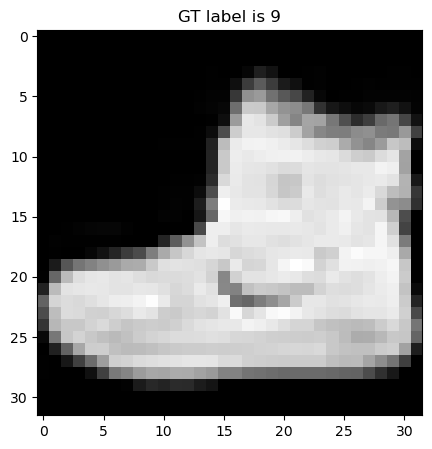

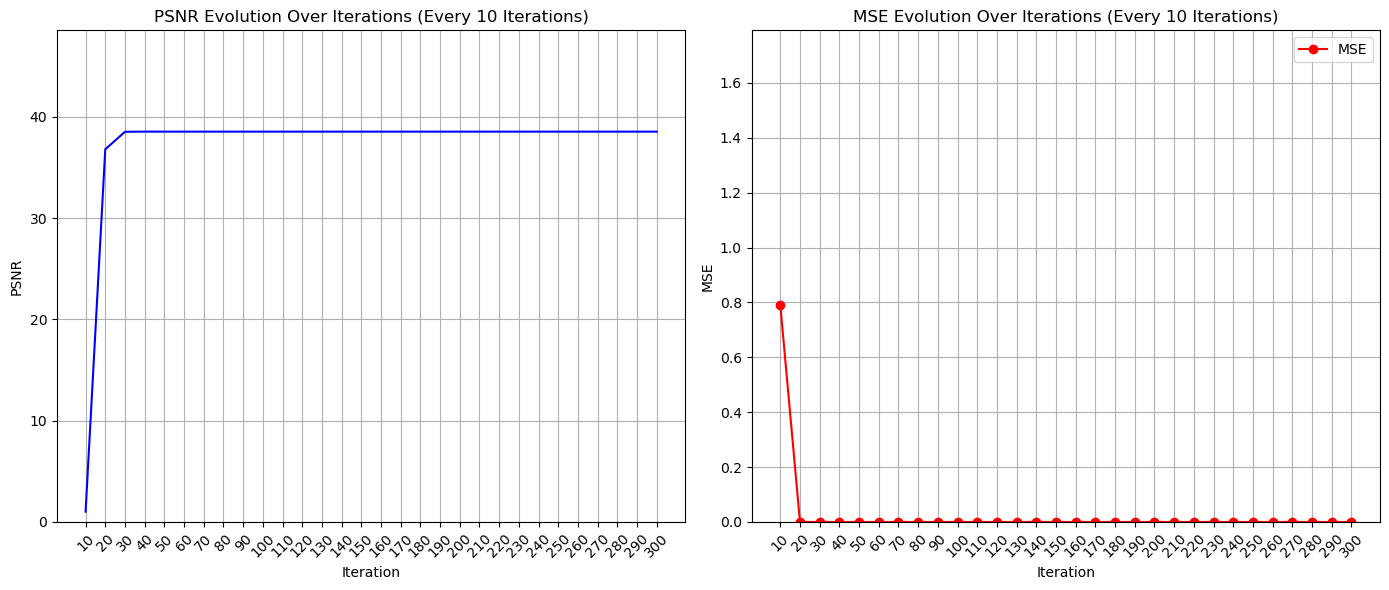

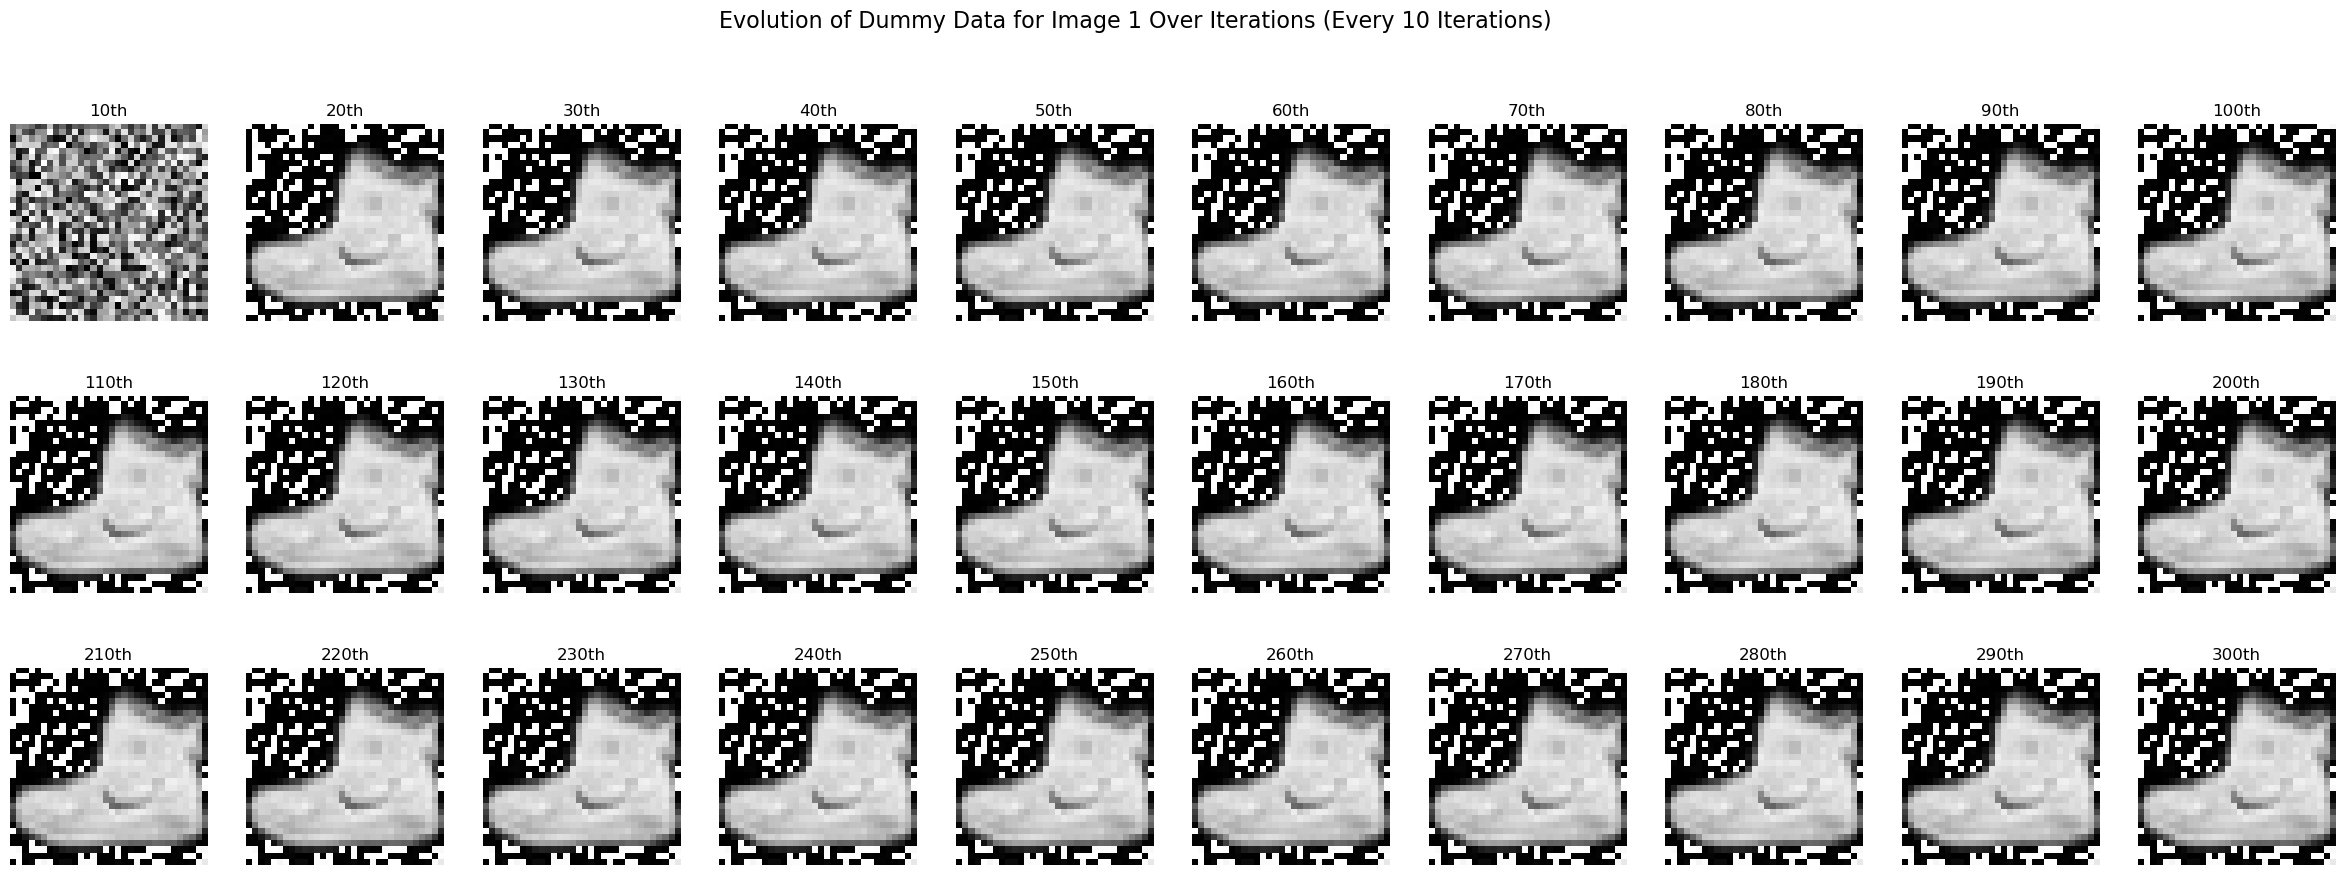

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.001: 38.54 at Iteration 40
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.001: 1.39798e-04 at Iteration 40
2.3.1 0.18.1
Running on cpu


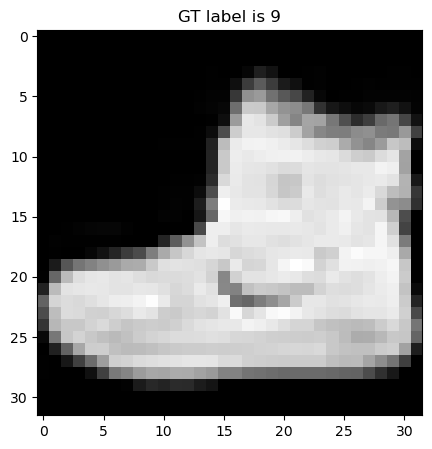

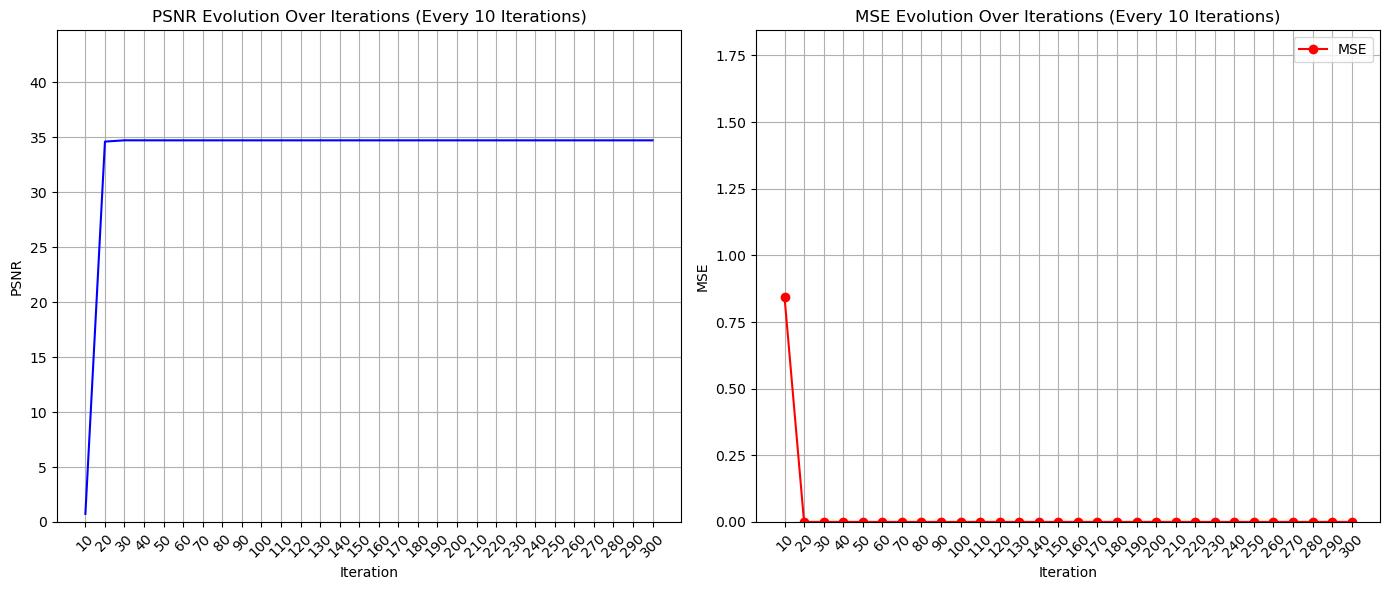

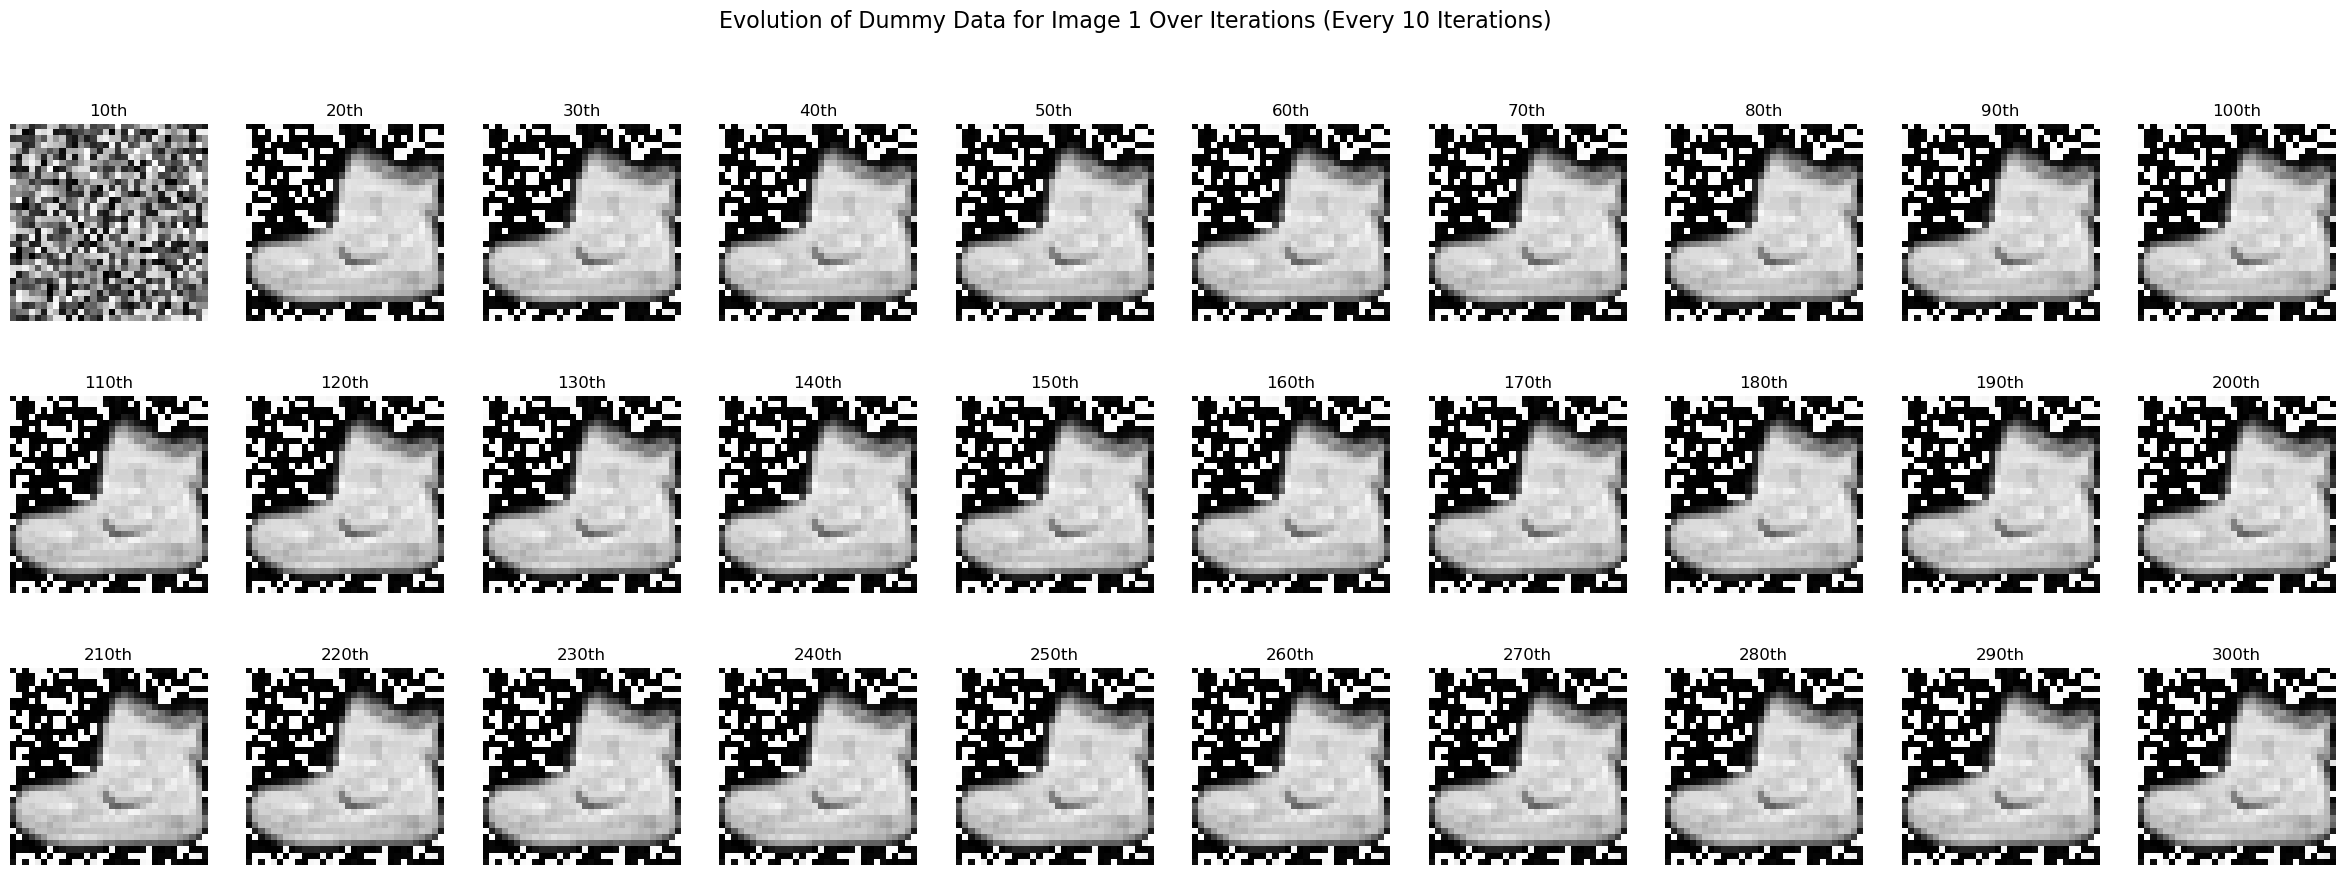

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Laplacian noise with strength of 0.001: 34.70 at Iteration 30
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Laplacian noise with strength of 0.001: 3.38508e-04 at Iteration 30


In [20]:
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Gaussian", noise_strength=0.001)
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Laplacian", noise_strength=0.001)



#### evaluate the privacy test with different noise strength (0.1.0.01,0.001,0.0001)

2.3.1 0.18.1
Running on cpu


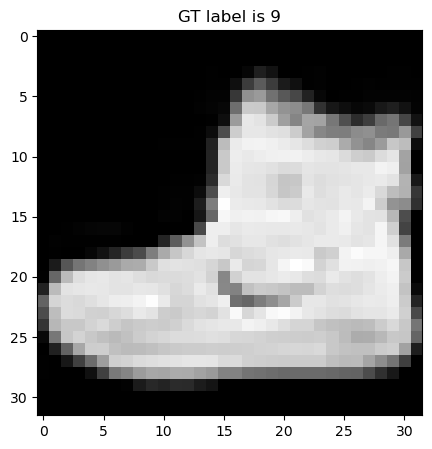

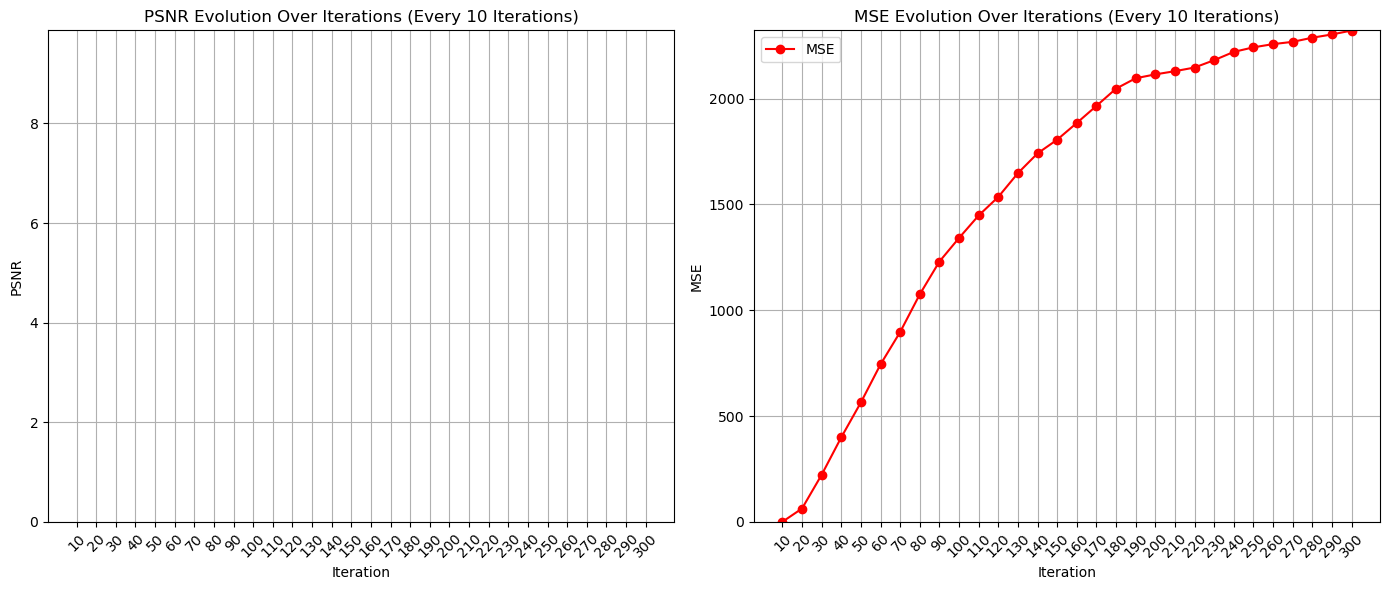

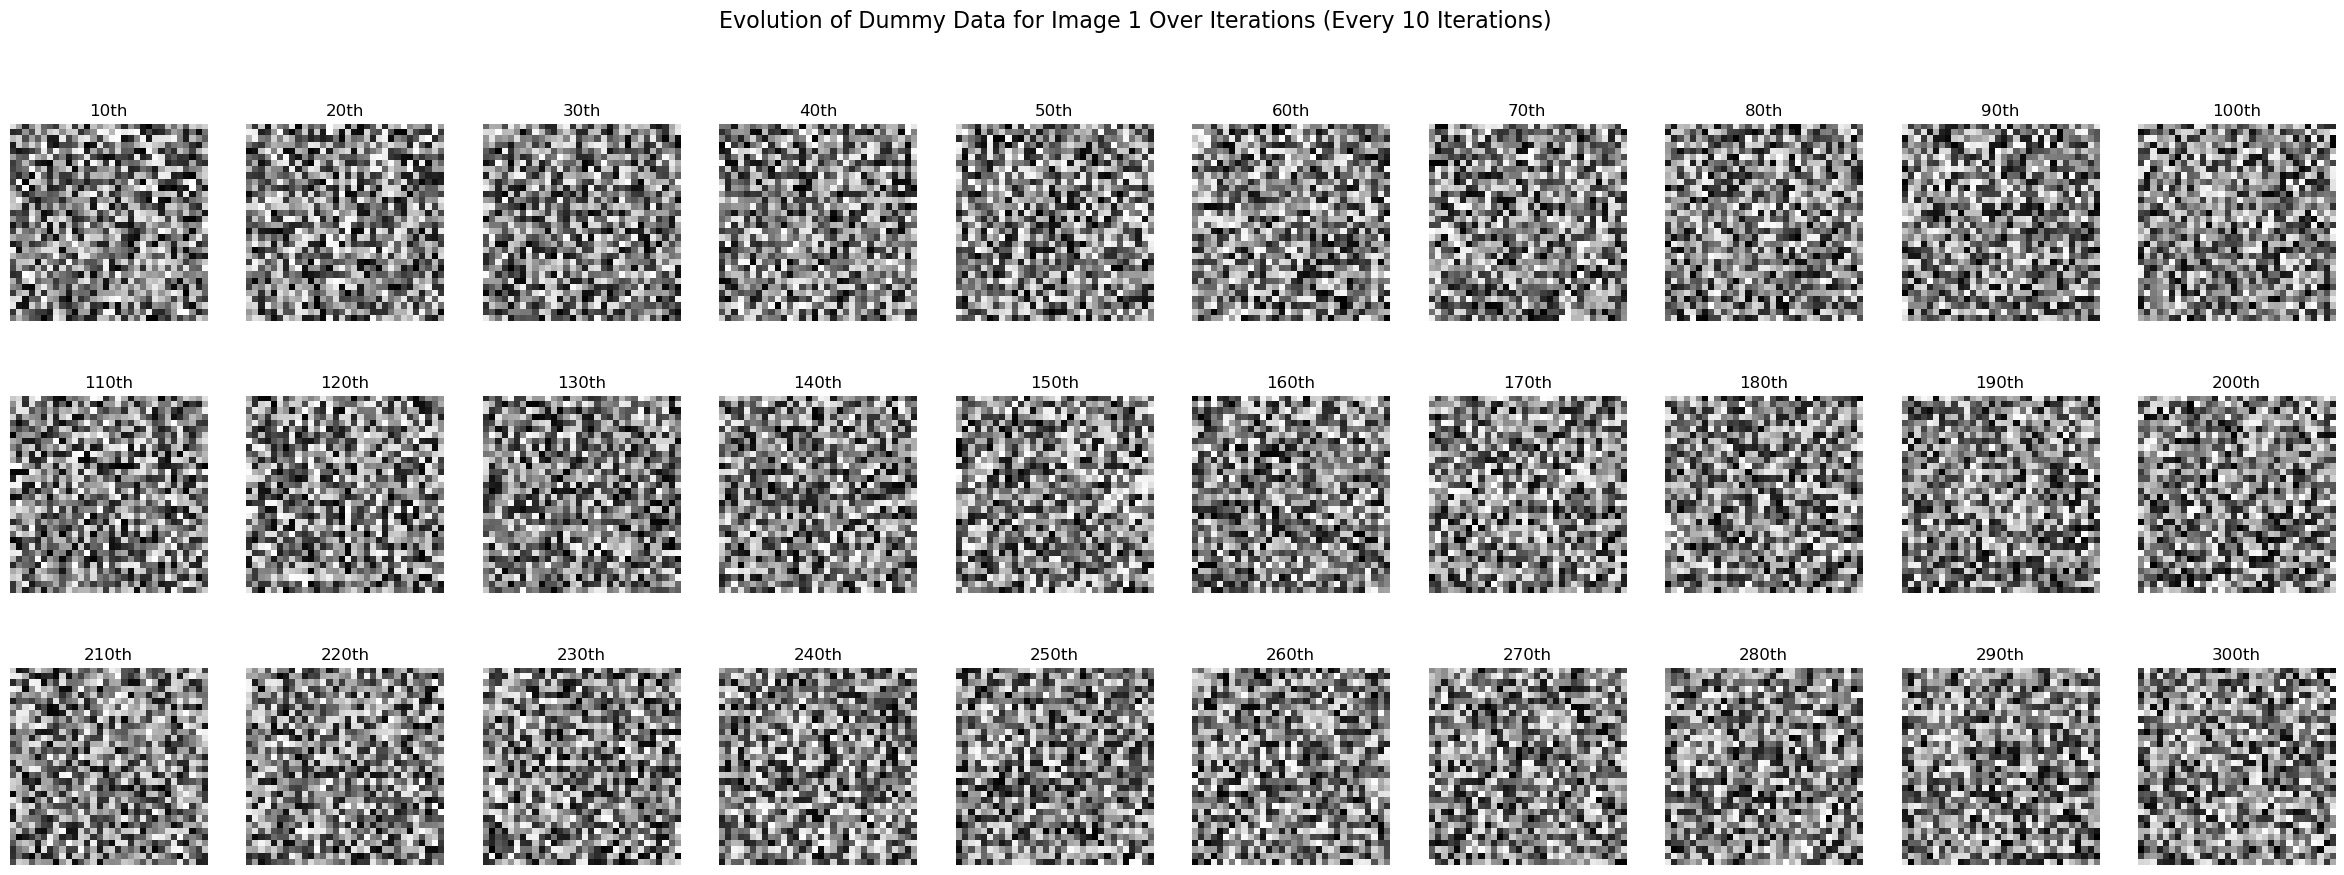

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.1: -0.13 at Iteration 10
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.1: 1.03110e+00 at Iteration 10
2.3.1 0.18.1
Running on cpu


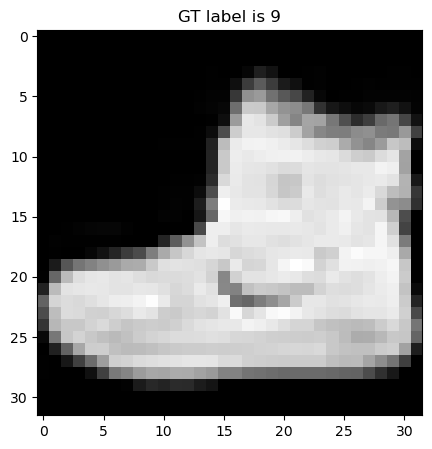

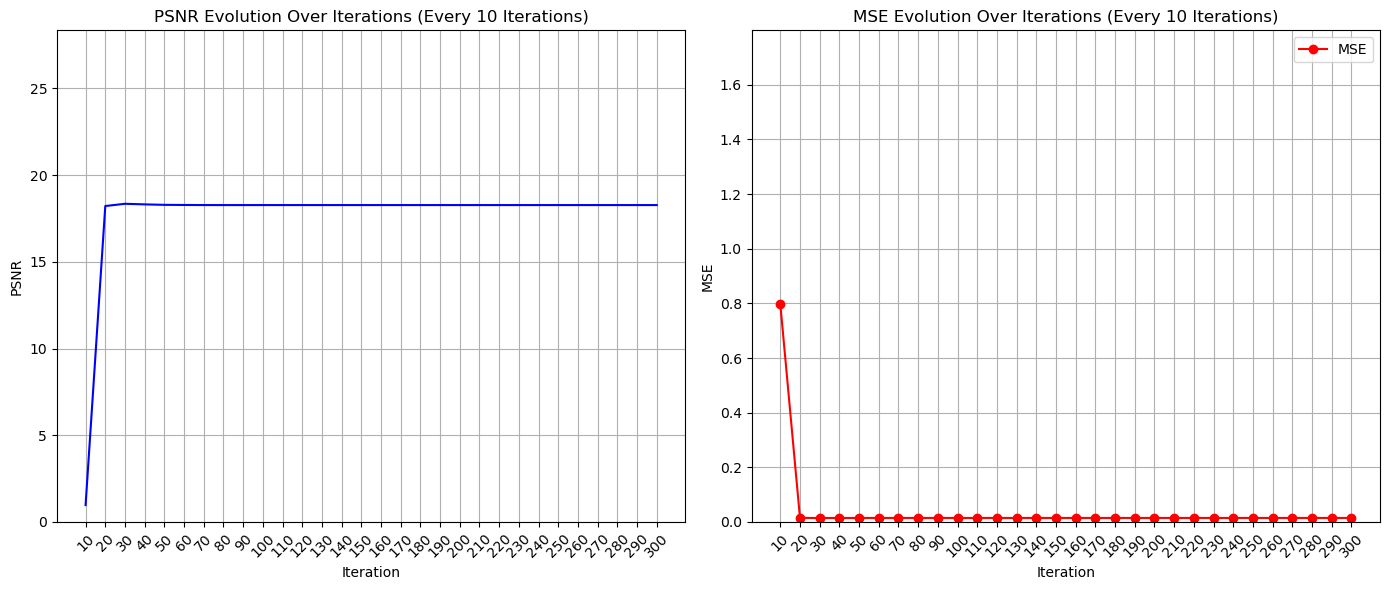

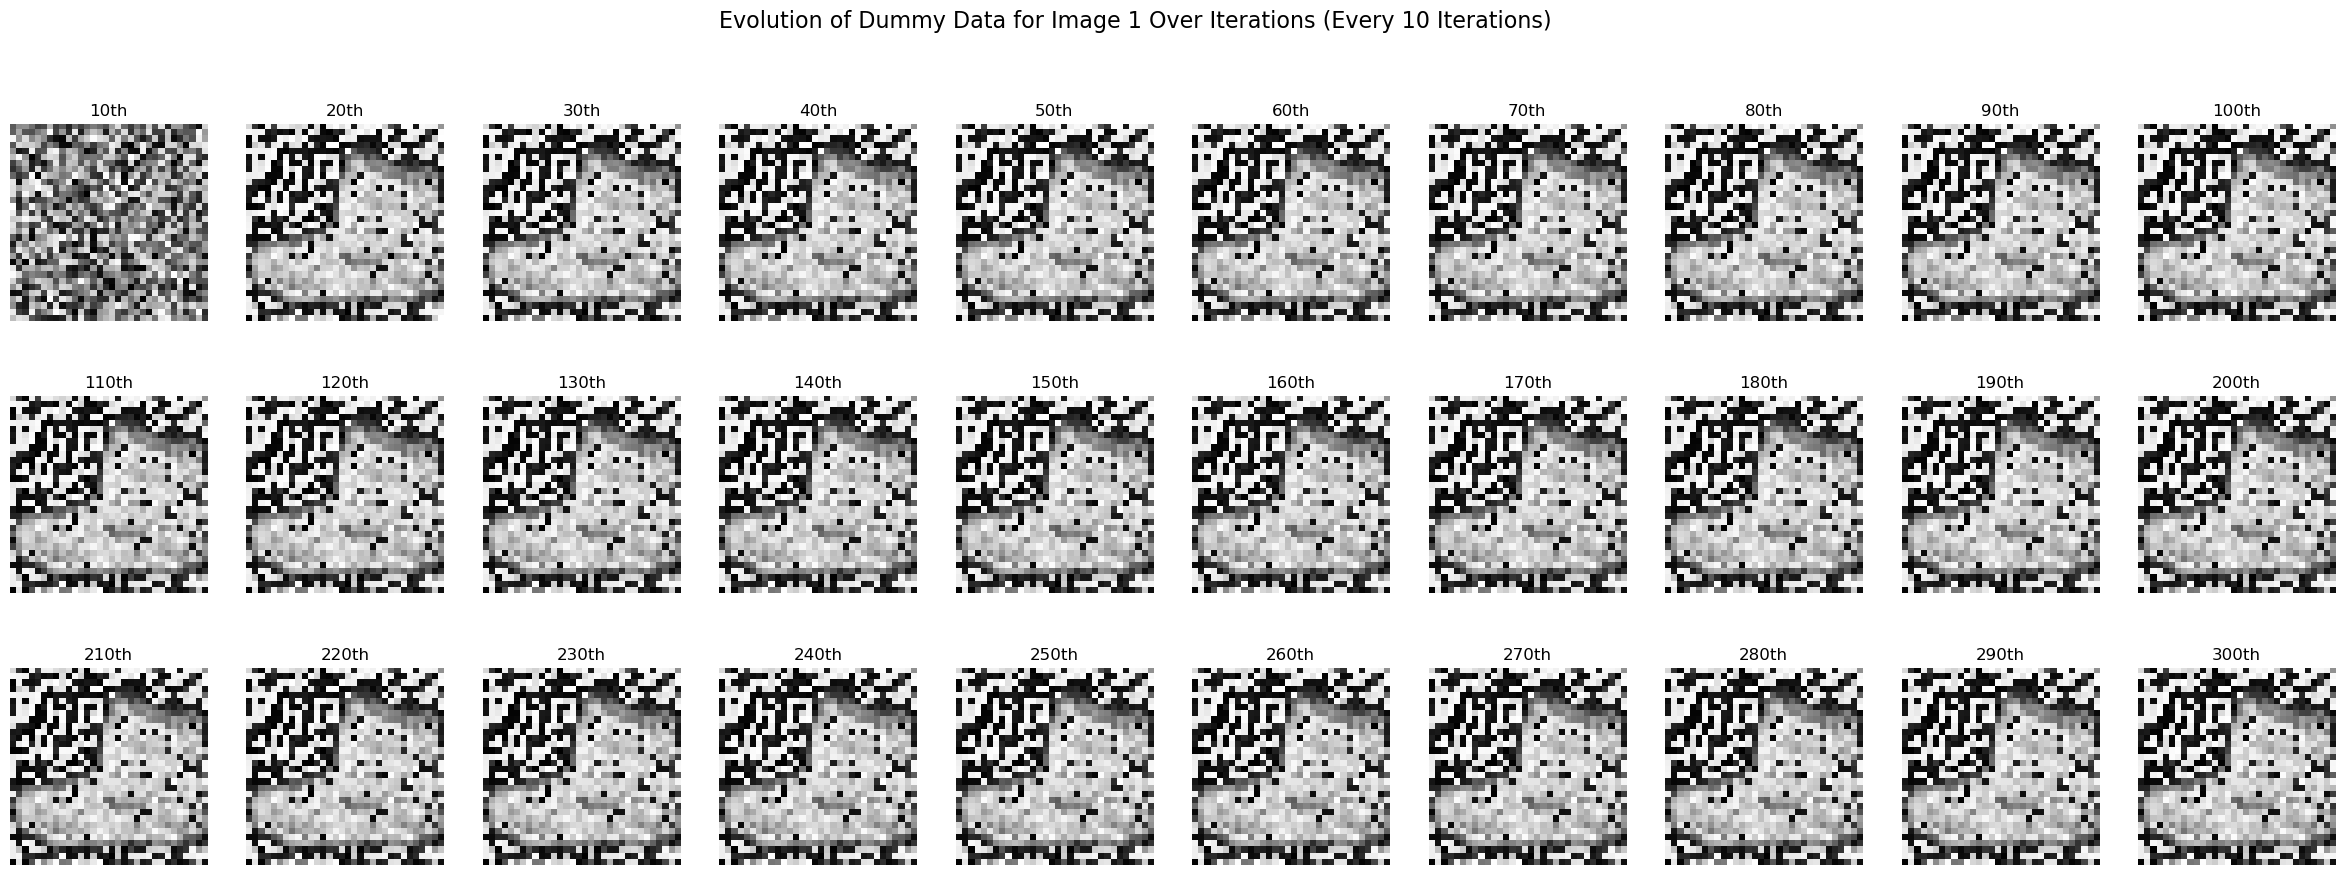

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.01: 18.35 at Iteration 30
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.01: 1.46337e-02 at Iteration 30
2.3.1 0.18.1
Running on cpu


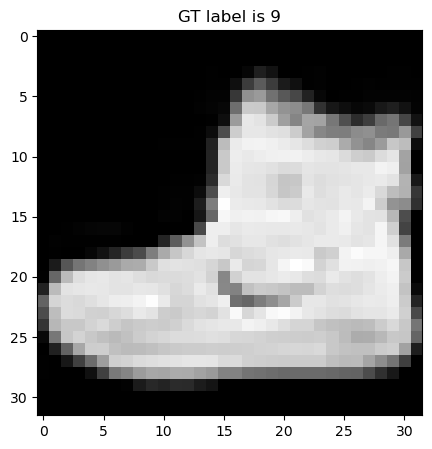

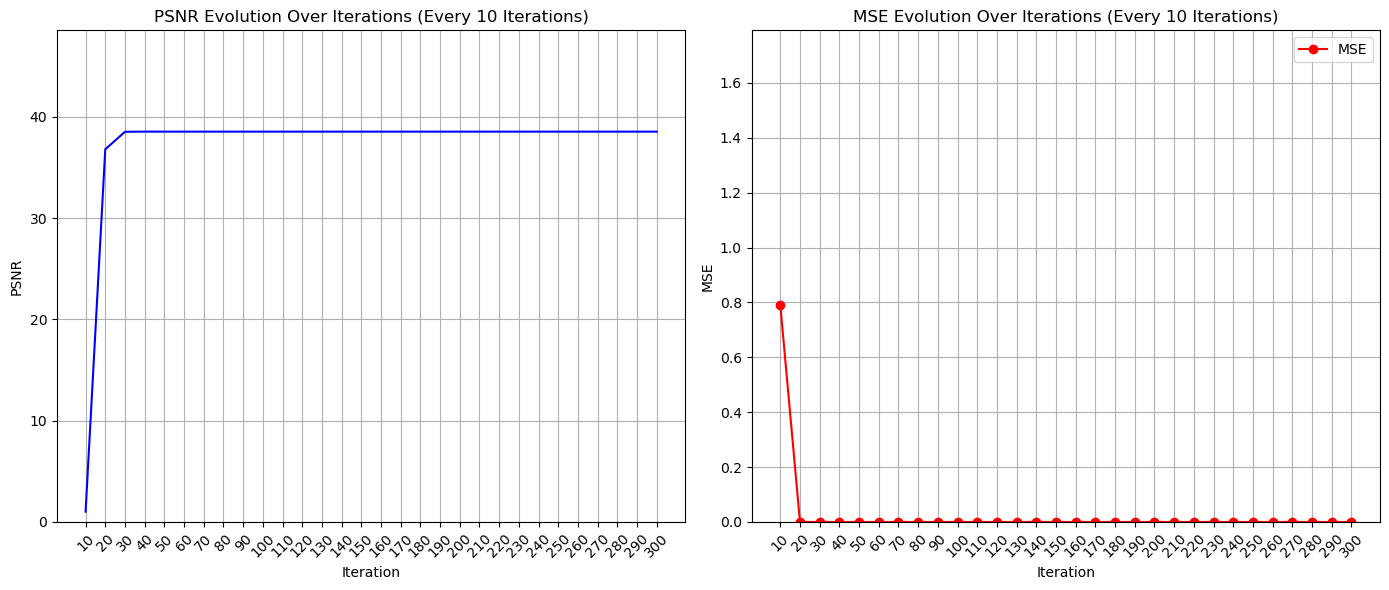

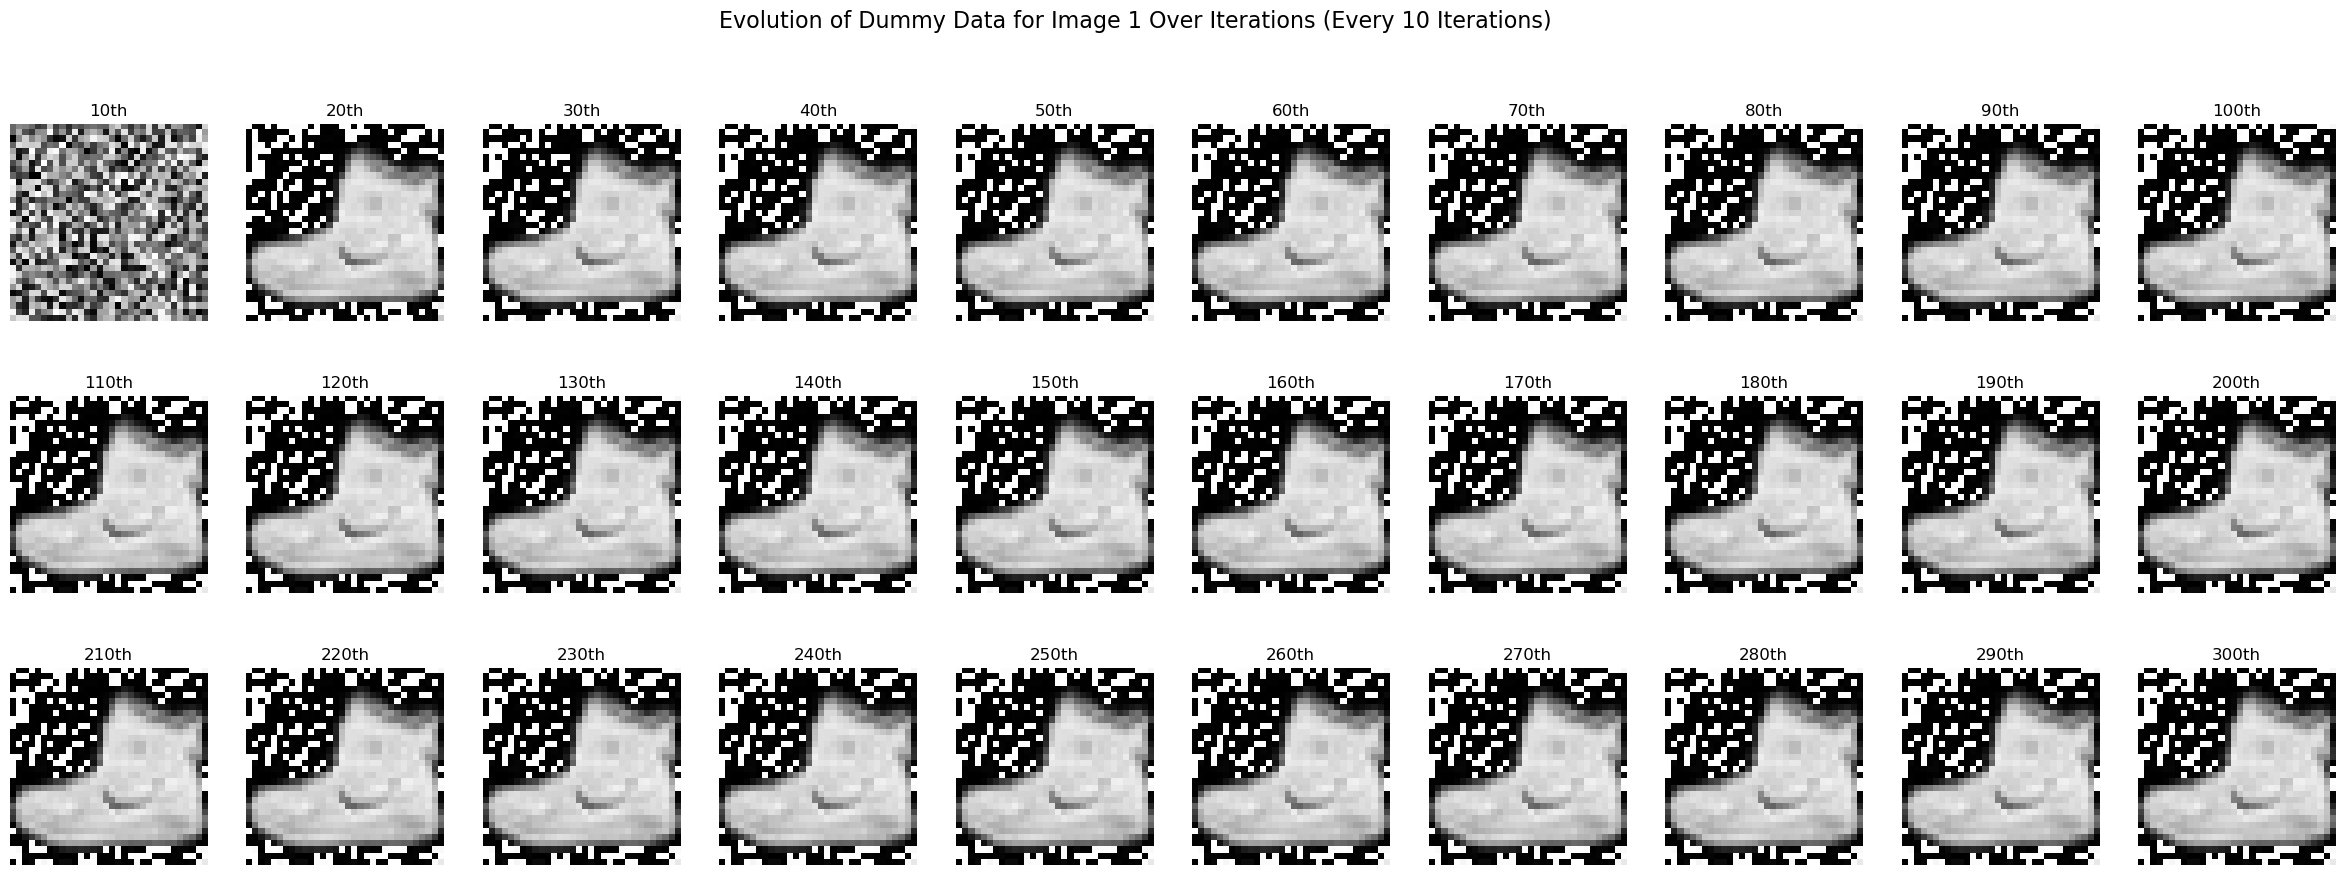

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.001: 38.54 at Iteration 40
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.001: 1.39798e-04 at Iteration 40
2.3.1 0.18.1
Running on cpu


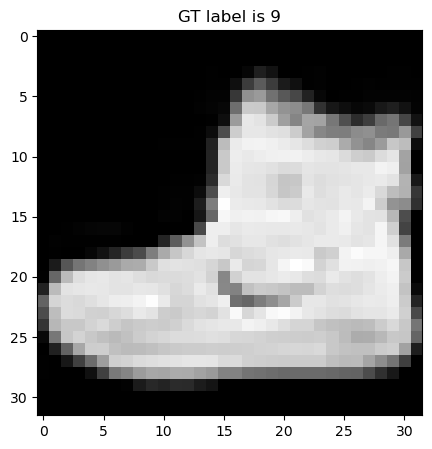

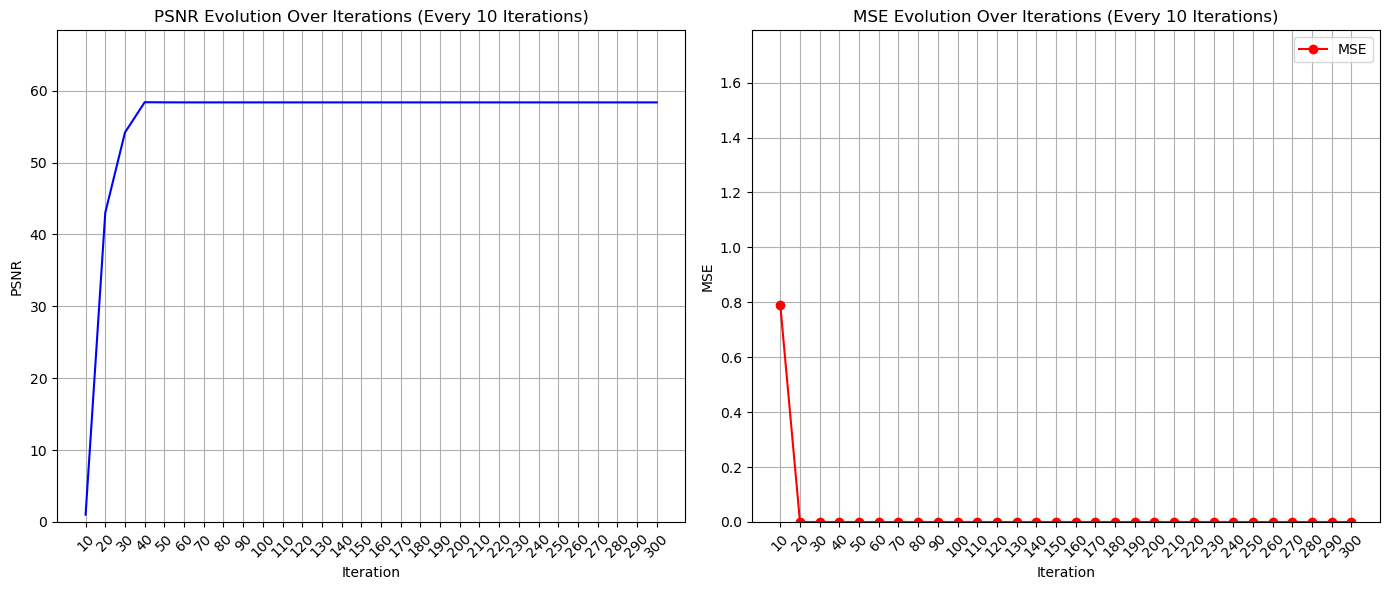

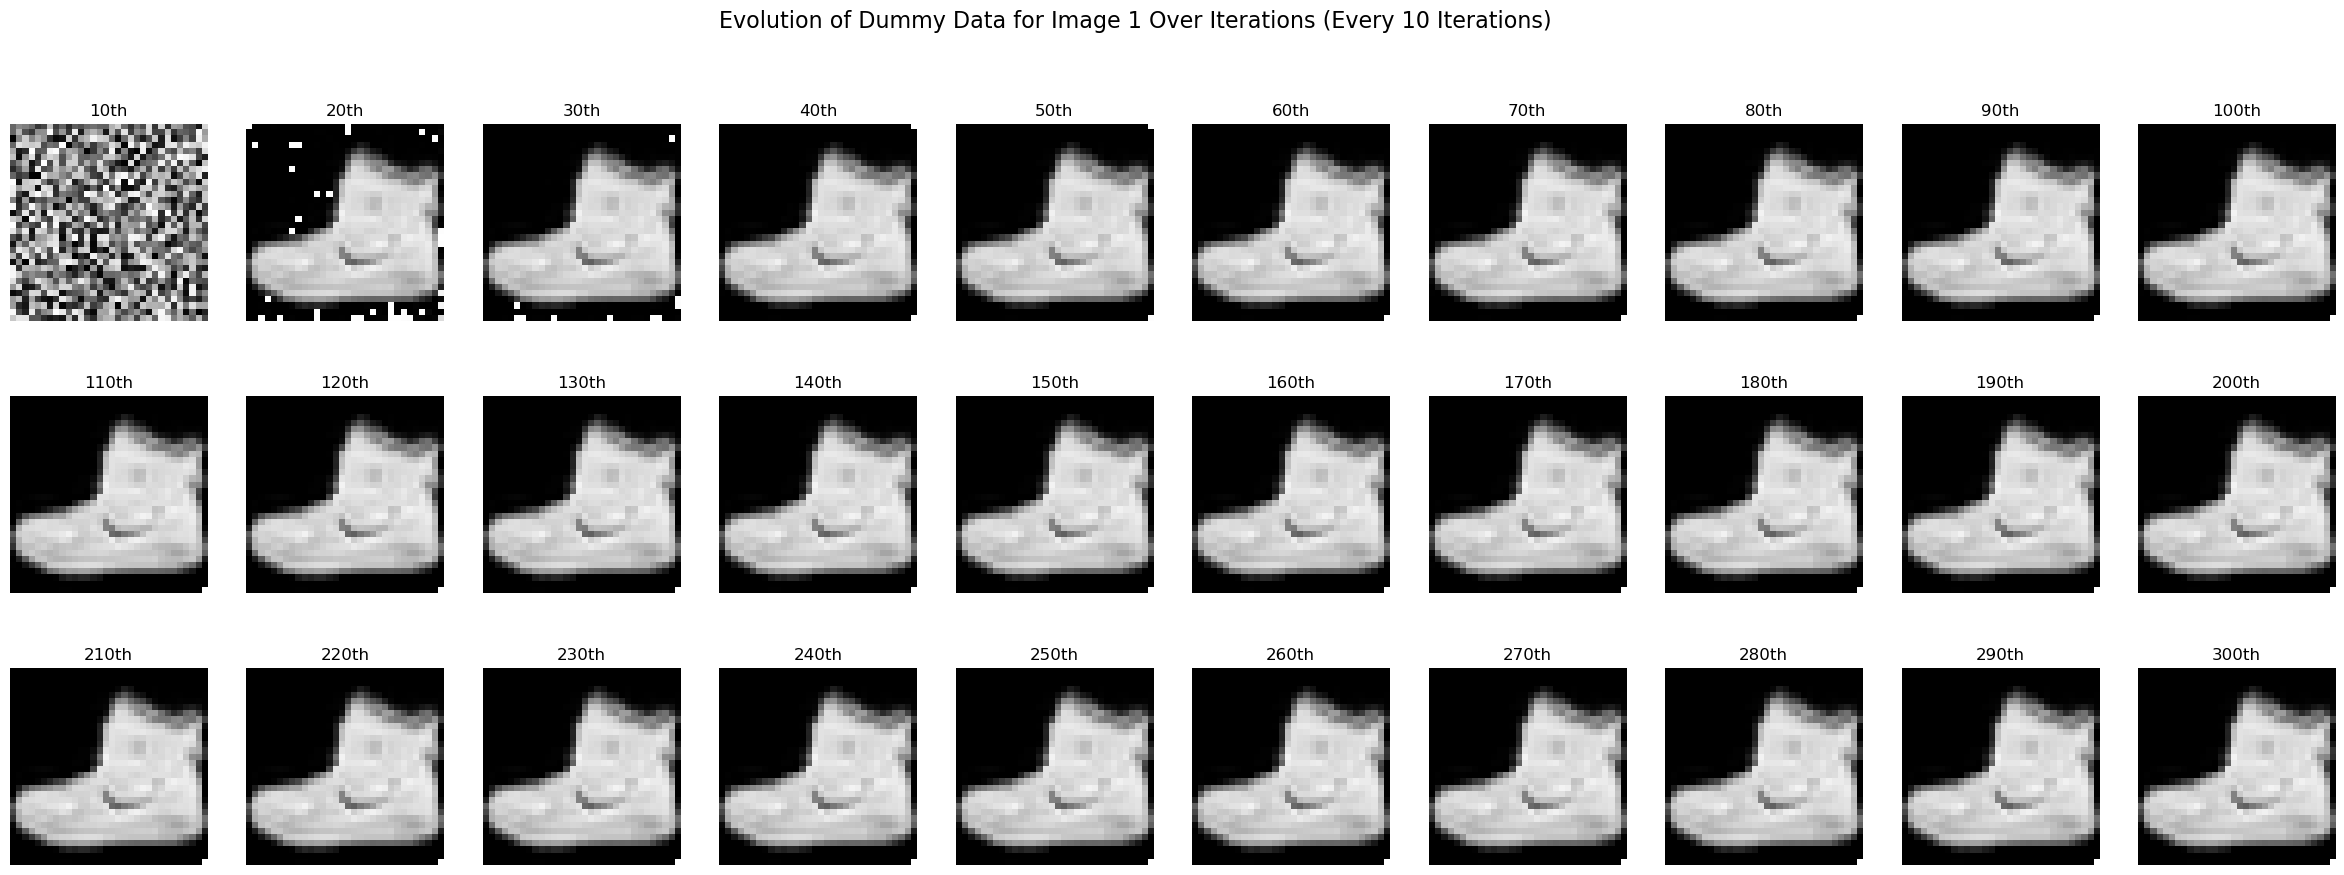

Maximum PSNR for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.0001: 58.39 at Iteration 40
Minimum MSE for FashionMNIST dataset with 1 batch size with model of <class '__main__.LeNet'> with adding Gaussian noise with strength of 0.0001: 1.44850e-06 at Iteration 40


In [21]:
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Gaussian", noise_strength=0.1)
run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Gaussian", noise_strength=0.01)

run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Gaussian", noise_strength=0.001)

run_experiment(dataset_type="FashionMNIST", batch_size=1, model_class=LeNet, noise_type="Gaussian", noise_strength=0.0001)



### accuracy test
